In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import time
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from swipes.isosurface import isosurface
import matplotlib.tri as mtri
from skimage import measure

from skimage.draw import ellipsoid
import matplotlib
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
from scipy.optimize import curve_fit
%matplotlib notebook

# Circle calculation

In [112]:
f = open("sample_sphere.ply","r")
lines = f.readlines()
lines = np.array([[float(f) for f in l.rstrip("\n").split()] for l in lines])
f.close()
coords = lines[:,:3]
normals = lines[:,3:6]

f = open("t.ply","r")
lines = f.readlines()
lines = np.array([[int(f) for f in l.rstrip("\n").split()] for l in lines])
f.close()
triangle_indices = lines[:,1:]

<IPython.core.display.Javascript object>


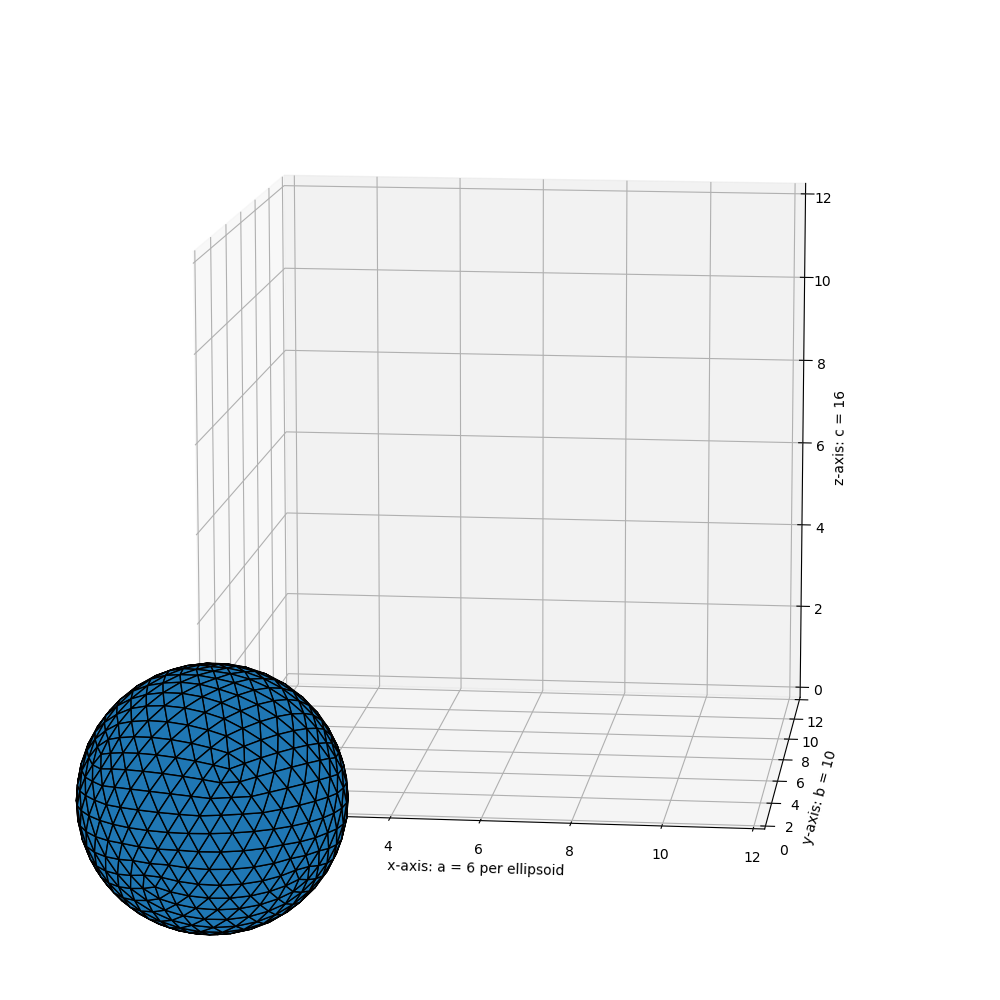

In [96]:
# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(8,8,8, levelset=True)


# Use marching cubes to obtain the surface mesh of these ellipsoids
# verts, faces, normals, values = measure.marching_cubes_lewiner(ellip_base, 0)


# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(coords[triangle_indices])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)


ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")


ax.set_xlim(0, 12)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 12)  # b = 10
ax.set_zlim(0, 12)  # c = 16

plt.tight_layout()
plt.show()

# Least Squares solution

In [113]:
edge1 = coords[triangle_indices[:,2]] - coords[triangle_indices[:,1]]
edge2 = coords[triangle_indices[:,0]] - coords[triangle_indices[:,2]]
edge3 = coords[triangle_indices[:,1]] - coords[triangle_indices[:,0]]

normaldiff0 = normals[triangle_indices[:,2]] - normals[triangle_indices[:,1]]
normaldiff1 = normals[triangle_indices[:,0]] - normals[triangle_indices[:,2]]
normaldiff2 = normals[triangle_indices[:,1]] - normals[triangle_indices[:,0]]

# find per face coordinates
U = edge1/np.sqrt((edge1**2).sum(axis=1,keepdims=True))
N = np.cross(edge1, edge2)
TriangleAreas = np.sqrt((N**2).sum(axis=1,keepdims=True))
N = N/np.sqrt((N**2).sum(axis=1,keepdims=True))
V = np.cross(U,N)

# finding per vertex normals
vertexnormals = np.zeros((coords.shape[0],3))
for i in range(triangle_indices.shape[0]):
    t = triangle_indices[i]
    vertexnormals[t[0]] = coords[t[1]] - coords[t[0]]
    vertexnormals[t[1]] = coords[t[2]] - coords[t[1]]
    vertexnormals[t[2]] = coords[t[0]] - coords[t[2]]


vertexnormals = np.cross(vertexnormals, normals)
vertexnormals = vertexnormals/np.sqrt((vertexnormals**2).sum(axis=1,keepdims=True))
vertexnormals2 = np.cross(vertexnormals, normals)

matTot = np.zeros((triangle_indices.shape[0],3,3))
for i in range(triangle_indices.shape[0]):
    mat = np.zeros((3,3))
    b = np.zeros((3,1))
    
    e1U = np.dot(edge1[i], U[i])
    e2U = np.dot(edge2[i], U[i])
    e3U = np.dot(edge3[i], U[i])
    
    eU = np.array([e1U, e2U, e3U])
    #print(eU)
    e1V = np.dot(edge1[i], V[i])
    e2V = np.dot(edge2[i], V[i])
    e3V = np.dot(edge3[i], V[i])
    
    eV = np.array([e1V, e2V, e3V])
    #print(eV)
    mat[0,0] = (eU*eU).sum()
    mat[0,1] = (eU*eV).sum()
    mat[2,2] = (eV*eV).sum()
    
    mat[1,1] = mat[0,0] + mat[2,2]
    mat[1,0] = mat[0,1]
    mat[1,2] = mat[0,1]
    mat[2,1] = mat[1,2]
    
    
    normD = np.vstack((normaldiff0[i], normaldiff1[i],normaldiff2[i]))

    normDU = (normD*U[i]).sum(axis=1)
    normDV = (normD*V[i]).sum(axis=1)
    
    b[0] = (normDU*eU).sum()
    b[1] = (normDU*eV).sum() + (normDV*eU).sum()
    b[2] = (normDV*eV).sum()
    
    invmat = np.linalg.inv(mat)
    ans = np.dot(invmat, b)
    
    II = np.zeros((2,2))
    II[0,0] = ans[0]
    II[1,1] = ans[2]
    II[1,0] = ans[1]
    II[0,1] = ans[1]
    
    eig,eigv = np.linalg.eig(II)
    print(eig)

[0.34100356 0.34110436]
[0.34108881 0.34112041]
[0.34105548 0.34110436]
[0.34105548 0.34110436]
[0.34100356 0.34110436]
[0.3410695 0.3411896]
[0.34107421 0.34117647]
[0.34105854 0.34109327]
[0.3410521  0.34118476]
[0.34110689 0.34117935]
[0.34112425 0.34117507]
[0.34116221 0.34116563]
[0.341079   0.34108835]
[0.3411621 0.3411652]
[0.34112425 0.34117507]
[0.34106592 0.34110411]
[0.34116289 0.34108485]
[0.34108881 0.34112041]
[0.34112004 0.34107264]
[0.34105153 0.341147  ]
[0.34105548 0.34110436]
[0.34097982 0.3311274 ]
[0.34087379 0.33091036]
[0.34069801 0.33078581]
[0.34069737 0.33078543]
[0.34086203 0.3309144 ]
[0.34097003 0.33117048]
[0.34004332 0.3410719 ]
[0.33114972 0.34101963]
[0.33040076 0.34078581]
[0.33119812 0.32966978]
[0.34080825 0.3304204 ]
[0.33088669 0.34087449]
[0.32961318 0.34069466]
[0.33003652 0.3292897 ]
[0.33004673 0.32966971]
[0.33004486 0.32929461]
[0.34068109 0.32960941]
[0.33081701 0.34068722]
[0.32932172 0.34064516]
[0.32943484 0.329316  ]
[0.32915039 0.329453

[0.32947033 0.3290897 ]
[0.33008318 0.32925088]
[0.32965941 0.33009851]
[0.3311797  0.32965891]
[0.34079312 0.33037895]
[0.33118919 0.34098629]
[0.34010324 0.34112615]
[0.3410485  0.33121825]
[0.34081812 0.33038113]
[0.34088774 0.33085645]
[0.3406912  0.32957346]
[0.34069776 0.33078862]
[0.34069676 0.32937304]
[0.34075486 0.33074497]
[0.34070788 0.32960439]
[0.34083675 0.33085048]
[0.34075171 0.33043867]
[0.34097001 0.33119729]
[0.34106112 0.34002104]
[0.3410521  0.34118476]
[0.34107421 0.34117647]
[0.34097969 0.33118316]
[0.34088269 0.33085797]
[0.34063761 0.33074811]
[0.34068882 0.330748  ]
[0.34086111 0.33086079]
[0.34108135 0.33117957]
[0.34003116 0.3410796 ]
[0.33116019 0.34100299]
[0.33043648 0.34078676]
[0.3311789  0.32961408]
[0.34078789 0.33034724]
[0.33086098 0.34086471]
[0.32954473 0.34065107]
[0.3299564  0.32926144]
[0.33004306 0.32960946]
[0.33008288 0.32931188]
[0.34069107 0.3296676 ]
[0.33077962 0.3407171 ]
[0.32940654 0.34061293]
[0.32949524 0.32940654]
[0.32907959 0.32

[0.34097554 0.33108232]
[0.34111165 0.34001815]
[0.34110689 0.34117935]
[0.34108835 0.341079  ]
[0.34102955 0.33115147]
[0.34087801 0.33087859]
[0.34067579 0.3307823 ]
[0.34070643 0.33077841]
[0.34090016 0.3308712 ]
[0.34096473 0.33116422]
[0.34011152 0.341079  ]
[0.33115147 0.34102955]
[0.33033559 0.34078061]
[0.33113591 0.32954352]
[0.34078061 0.33033559]
[0.33087859 0.34087801]
[0.32958916 0.34068319]
[0.32998971 0.32926445]
[0.33001729 0.32954352]
[0.32998971 0.32926445]
[0.34068319 0.32958916]
[0.33078237 0.34067587]
[0.32939856 0.34064171]
[0.32946698 0.32939187]
[0.32911171 0.32948496]
[0.32920646 0.32895083]
[0.32948496 0.32911171]
[0.32939187 0.32946698]
[0.34064186 0.32939856]
[0.33077824 0.34070652]
[0.32959652 0.3407038 ]
[0.32927205 0.33005529]
[0.32907977 0.32947211]
[0.32895428 0.329142  ]
[0.32895546 0.32895083]
[0.329142   0.32895428]
[0.32947211 0.32907977]
[0.33005455 0.3292721 ]
[0.34070412 0.32959623]
[0.33087115 0.34090095]
[0.33043815 0.34082358]
[0.32966096 0.33

In [58]:
# calculate triangle areas
points = coords[triangle_indices]
side1 = points[:,1] - points[:,0]
side2 = points[:,0] - points[:,2]
area = np.sqrt((np.cross(side1,side2)**2).sum(axis=1))/2
neighbors = [[] for _ in range(coords.shape[0])]

vertex_neighbor_area = np.zeros((coords.shape[0],))
vertex_matrix = np.zeros((coords.shape[0],3,3))

for (i,val) in enumerate(points):
    # index of the triangles in the vertex data
    t = faces[i]
    A = area[i]
    print(i)
    for j in range(3):
        norm = normals[t[j]]
        vert = coords[t[j]]
        dyad = np.outer(norm, norm)
        tangential = np.eye(3) - dyad
        for k in range(3):
            if (j != k):
                if t[k] not in neighbors[t[j]]:
                    diff =  coords[t[k]] - vert
                    diffsq = (diff**2).sum()

                    kappa = 2* np.dot(diff, norm)/diffsq
                    T = np.dot(tangential, diff)
                    T = T/np.sqrt((T**2).sum())

                    matrix = A*kappa*np.outer(T,T)
                    vertex_matrix[t[j]] += matrix         
                    vertex_neighbor_area[t[j]] += A
                    
                    neighbors[t[j]].append(t[k])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

IndexError: index 642 is out of bounds for axis 0 with size 642

In [200]:
Id = getNearbyIndicesTriangularMesh(coords,triangle_indices)
N = findNeighborsNVertexAway(Id, 2)

In [224]:
vertex_neighbor_area[-1]

0.0

In [64]:
ix = 200

q = vertex_matrix[ix]/vertex_neighbor_area[ix]
print(q)
E = np.array([1,0,0])

norm1 = ((E - normals[ix])**2).sum()
norm2 = ((E + normals[ix])**2).sum()

if (norm2 > norm1):
    sign = 1
else:
    sign = -1
    
W = E + sign*normals[ix]
W = W / np.sqrt((W**2).sum())
Q = np.eye(3) - 2*np.outer(W,W)
l = Q.T.dot(q).dot(Q)
sub = l[1:,1:]
eig,eigv = np.linalg.eig(sub)
k1 = 3*eig[1] - eig[0]
k2 = 3*eig[0] - eig[1]
print("eig0 = ", eig[0])
print("eig1 = ", eig[1])
print("k1 = ", k1)
print("k2 = ", k2)
print("mean curvature = ", 1/2*(k1+k2))

[[-0.07846227 -0.03463956  0.08044263]
 [-0.03463956 -0.14891286 -0.0195878 ]
 [ 0.08044263 -0.0195878  -0.10519553]]
eig0 =  -0.1561600956436604
eig1 =  -0.17641056521145554
k1 =  -0.37307159999070616
k2 =  -0.29206972171952567
mean curvature =  -0.3325706608551159


In [86]:
tri = [[] for _ in range(verts.shape[0])]

for i in range(faces.shape[0]):
    t = faces[i]
    for j in range(3):
        id1 = t[j]
        for k in range(3):
            if j != k:
                id2 = t[k]
                if id2 not in tri[id1]:
                    tri[id1].append(id2)

In [95]:
for i in range(verts.shape[0]):
    v = verts[i]
    T = np.eye(3) - np.outer(normals[i], normals[i])
    
    for j in range(len(tri[i])):
        diff = verts[tri[i][j]] - v
        if diff.sum() != 0:
            difftrans = np.dot(T, diff)
            difftrans = difftrans/np.sqrt((difftrans**2).sum())
            print(difftrans)

[ 0.01287239 -0.00340146 -0.99991136]
[ 6.31652864e-02 -9.98003079e-01 -4.24576600e-05]
[ 6.31652864e-02  4.24576600e-05 -9.98003079e-01]
[ 0.01287239  0.99991136 -0.00340146]
[ 0.01287239 -0.99991136  0.00340146]
[ 6.31652864e-02 -4.24576600e-05  9.98003079e-01]
[6.31652864e-02 9.98003079e-01 4.24576600e-05]
[0.01287239 0.00340146 0.99991136]
[ 0.25746547 -0.02321079 -0.96600869]
[ 0.36694633 -0.93012757 -0.0145977 ]
[ 0.03391414 -0.60880559  0.79259421]
[-0.24241043 -0.01797796  0.9700072 ]
[-0.36114955  0.93243757 -0.01145308]
[-0.41589175  0.63889312  0.64718594]
[-0.03497349  0.5639774  -0.8250493 ]
[-0.45035154  0.8928128  -0.00829468]
[-0.05934793 -0.42495889  0.90326506]
[ 0.16728609  0.24343645 -0.95538163]
[ 0.45386712 -0.89104782 -0.00619816]
[-0.03808822 -0.59733904  0.80108386]
[-0.3300702  -0.00563811  0.94393955]
[-0.15591229  0.8356886  -0.52660794]
[ 0.33559711 -0.00960266 -0.94195667]
[ 0.37193379 -0.92824155 -0.00573461]
[ 0.12216362 -0.02983645 -0.99206141]
[ 0.1820

[-0.39670629 -0.22782375 -0.88922464]
[-0.26359761  0.02368907 -0.96434181]
[-0.19234803 -0.65506959  0.73067508]
[0.29841345 0.03788223 0.95368462]
[0.52666858 0.84997885 0.01249659]
[ 0.45124714  0.85426054 -0.25809872]
[ 0.24905223  0.71230325 -0.65619896]
[-0.51739655 -0.85551974  0.01966707]
[-0.4047409   0.02780252 -0.91400866]
[0.43217227 0.02622267 0.90140973]
[ 0.10310686  0.69858968 -0.70805468]
[0.53014235 0.84770981 0.01836206]
[-0.25265308 -0.81550675  0.5206872 ]
[-0.49949218  0.01725145 -0.86614661]
[-0.02439693  0.631027   -0.77537715]
[0.51576637 0.01464931 0.85660402]
[0.63981588 0.73293655 0.23117018]
[0.67031411 0.595935   0.44219959]
[-0.50069403 -0.86543146  0.01827206]
[-0.02269624 -0.77626176  0.63000204]
[0.51722471 0.85573852 0.01379044]
[0.67365814 0.44010885 0.59370777]
[-0.0364076  -0.58680501 -0.80890937]
[-0.60258568 -0.79787832 -0.01675391]
[-0.57331556 -0.22286803  0.78844094]
[-0.04033009  0.51726366  0.85487531]
[ 0.61162968  0.79106524 -0.01117688]
[

[-0.73383132 -0.0231128  -0.67893843]
[ 0.75131053 -0.02069394  0.65962433]
[-0.64375648  0.76455015  0.03225927]
[-0.81000442  0.57085347 -0.13423546]
[-0.75637875 -0.05216404 -0.65205069]
[-0.0231128  -0.73383132 -0.67893843]
[-0.02069395  0.75131053  0.65962433]
[ 0.76455012 -0.64375651  0.03225929]
[0.63287984 0.25118652 0.73237179]
[ 0.85284756 -0.24681404  0.46014548]
[-0.79978591 -0.02489618 -0.59976885]
[-0.02489618 -0.79978591 -0.59976885]
[-0.0271447   0.81772553  0.57496793]
[-0.85596367  0.20090369 -0.47640729]
[ 0.86087592 -0.33833052  0.38003304]
[ 0.81772553 -0.0271447   0.57496793]
[ 0.79652965 -0.0187079  -0.60430997]
[ 0.59584911 -0.80274126 -0.02388118]
[ 0.27076342 -0.91807967  0.28951147]
[-0.33180539 -0.69782282  0.63478224]
[-0.78900168 -0.01039803  0.61430304]
[-0.52781994  0.84770076 -0.05300504]
[-0.01143962  0.87044967 -0.49212448]
[-0.63682392  0.77022431 -0.03478226]
[-0.01944161 -0.8617869   0.50689778]
[ 0.82717184 -0.50984598 -0.23631299]
[-0.02622287 -0

[-0.28902398  0.92695563  0.23920367]
[-0.02224223  0.98977859  0.14086737]
[ 0.65188435 -0.67249729 -0.35042002]
[ 0.92878221  0.00717207 -0.37055658]
[-0.89412368  0.00441895 -0.4477983 ]
[-0.17893731 -0.98107036  0.07404309]
[0.89468285 0.00394123 0.44668452]
[0.37707532 0.925548   0.03427963]
[-0.28467599  0.91230208 -0.29438835]
[0.56022658 0.81569788 0.14416361]
[-0.65798305 -0.73070721 -0.18200351]
[-0.01514375 -0.99441659  0.10443325]
[-0.92824154  0.00573468 -0.3719338 ]
[-0.02983668  0.99206139 -0.12216373]
[ 0.65622043 -0.67489577  0.3374766 ]
[0.92868984 0.00600458 0.37080876]
[ 0.23719708 -0.90412059 -0.35539203]
[-0.41081476 -0.91111351 -0.03321758]
[ 0.89503895  0.00600171 -0.4459476 ]
[-0.89370087  0.00672918  0.44861284]
[-0.59518611 -0.79871001  0.0884071 ]
[ 0.55311268  0.83102119 -0.05890794]
[-0.02290629 -0.96580939 -0.25823928]
[-0.93545623  0.019691    0.35289361]
[-0.01660284  0.96217905  0.27191144]
[ 0.64000038 -0.64594511 -0.41611828]
[ 0.93813291  0.00822487

[-0.00600446 -0.37080877  0.92868983]
[ 0.73070731  0.18200348 -0.65798294]
[ 0.99441659 -0.10443336 -0.01514341]
[ 0.67489574 -0.33747659  0.65622046]
[-0.00394134 -0.44668455  0.89468283]
[-0.81569786 -0.14416367  0.56022659]
[-0.92554801 -0.03427966  0.3770753 ]
[-0.91230202  0.29438841 -0.28467613]
[-0.00441914  0.44779837 -0.89412364]
[ 0.98107037 -0.07404307 -0.17893731]
[-0.67483943  0.27282664 -0.68568022]
[-0.99053107  0.13634839 -0.01604097]
[-0.00775861  0.25862056 -0.96594783]
[-0.00802049 -0.25665582  0.96646959]
[ 0.99165686 -0.12786795 -0.01632355]
[ 0.68622702 -0.27145355  0.67483735]
[-0.69236997  0.20309518 -0.69236997]
[-0.98923246  0.14616741 -0.00736361]
[-0.00736361  0.14616741 -0.98923246]
[-0.01125889 -0.14348825  0.98958797]
[ 0.98958797 -0.14348825 -0.01125889]
[-0.70852808  0.09431747 -0.69935125]
[-0.99325965  0.11590277 -0.00134771]
[-0.00574773  0.01733446 -0.99983323]
[-0.00960059 -0.01554382  0.9998331 ]
[ 9.93264378e-01 -1.15867169e-01 -8.21105165e-04]


[-6.45045739e-04 -4.47225788e-01  8.94420862e-01]
[-0.98104764 -0.10483653  0.1629565 ]
[-0.99172859  0.03772859 -0.12268235]
[-0.73786652  0.28770891 -0.61055432]
[-5.75307417e-04  4.47202564e-01 -8.94432522e-01]
[ 0.99168522  0.07565969 -0.10409627]
[ 0.00126111  0.52407355 -0.85167207]
[-0.99894748 -0.00256856  0.04579672]
[ 0.00117738 -0.52411896  0.85164425]
[ 0.99895212 -0.03966517  0.0228329 ]
[ 0.96193282  0.12491473 -0.24306697]
[ 0.62408073 -0.42105305  0.65820785]
[-0.65041714  0.46312239 -0.60205913]
[-0.99890196 -0.02856465  0.03713404]
[ 3.50788688e-11  6.09710745e-01 -7.92624001e-01]
[ 3.25643644e-11 -6.09710746e-01  7.92624001e-01]
[ 0.99890196 -0.02856465  0.03713404]
[ 0.96175189 -0.16701324  0.21711722]
[-3.10905233e-11 -3.71390685e-01 -9.28476687e-01]
[-0.77639742 -0.23406662 -0.58516652]
[-0.99969364 -0.00919245 -0.02298111]
[-3.25535192e-11  3.71390684e-01  9.28476688e-01]
[ 0.99969364 -0.00919245 -0.02298111]
[0.69744686 0.26615212 0.66538028]
[-0.68304317 -0.188

[ 0.01659528  0.9998525  -0.00442541]
[ 0.70571674 -0.68304317 -0.18819115]
[ 0.96623493  0.         -0.25766267]
[-0.96646959  0.00802049 -0.25665582]
[ 0.01632356 -0.99165686 -0.12786796]
[0.01604097 0.99053107 0.1363484 ]
[ 0.72039599 -0.68622702  0.10060866]
[0.96594783 0.00775861 0.25862056]
[-0.96646959  0.0080204   0.25665583]
[ 0.01632335 -0.99165686  0.12786802]
[ 0.01604072  0.99053108 -0.13634833]
[ 0.72039596 -0.68622705 -0.10060865]
[ 0.96594783  0.00775847 -0.25862055]
[-0.96712962  0.0152906  -0.25382374]
[ 0.0152906  -0.96712962 -0.25382374]
[-0.68471686  0.72871473  0.01173276]
[0.01479143 0.96514021 0.2613151 ]
[ 0.72871473 -0.68471686  0.01173276]
[0.96514021 0.01479143 0.2613151 ]
[-0.96712963  0.01529085  0.25382368]
[ 0.01529085 -0.96712963  0.25382368]
[-0.68471688  0.72871471 -0.01173275]
[ 0.01479156  0.9651402  -0.26131513]
[ 0.72871471 -0.68471688 -0.01173275]
[ 0.9651402   0.01479156 -0.26131513]
[-0.96303307  0.02693795 -0.26803293]
[ 0.00994105 -0.93637194

[0.71841561 0.03088068 0.69492833]
[-0.94393955  0.33007021 -0.00563808]
[0.52660822 0.15591207 0.83568847]
[-0.68736045  0.04618865 -0.72484634]
[ 0.00701442 -0.34342461 -0.93915405]
[0.00926987 0.33695008 0.94147688]
[0.59284601 0.02528611 0.80491877]
[ 0.89971247 -0.28418392  0.33129589]
[ 0.93915407 -0.34342457  0.00701433]
[-0.80491852  0.02528589  0.59284636]
[-0.33129555 -0.28418405  0.89971256]
[-0.94147686  0.33695013  0.00926974]
[ 0.00960256 -0.33559707  0.94195668]
[-0.83568846  0.1559121   0.52660823]
[ 0.00563808  0.33007021 -0.94393955]
[ 0.5973394   0.038088   -0.80108361]
[ 0.0204153   0.40266082 -0.91512156]
[-0.90830787  0.41749465  0.0259812 ]
[-0.66558566 -0.02160633  0.74600865]
[ 0.02569812 -0.4207145   0.90682905]
[ 0.29521746  0.27302062 -0.91559073]
[ 0.7358905  -0.04328515 -0.6757156 ]
[ 0.90076897 -0.43391033  0.01836023]
[-0.90654867  0.42058735  0.03571822]
[ 0.01388607  0.5029081  -0.86422834]
[ 0.02597575 -0.5171727   0.8554868 ]
[ 0.89492401 -0.44590185

[ 0.75230819 -0.61850765  0.22689354]
[ 0.8029032  -0.59599193 -0.01183505]
[-0.44800555  0.05250799 -0.8924875 ]
[0.34459537 0.03794923 0.93798395]
[-0.80575716  0.59220366 -0.00708664]
[0.14281585 0.19677264 0.96999184]
[-0.30097041  0.0177537  -0.95346821]
[ 0.00851112 -0.25329397 -0.96735191]
[0.01091142 0.23751453 0.9713227 ]
[0.2716517  0.00984647 0.96234526]
[ 0.72969636 -0.51697713  0.44752416]
[ 0.79799222 -0.60256244  0.01126591]
[ 0.36412327  0.0624712  -0.92925325]
[-0.46445159  0.02870731  0.8851331 ]
[ 0.13649784 -0.42543616  0.89463535]
[-0.80171053  0.59762673  0.01012485]
[-0.63085946  0.20268864  0.74895504]
[ 0.01040132 -0.25067183  0.96801624]
[-0.30378822  0.01500148  0.95262147]
[-0.76964252  0.56892064  0.28979251]
[ 0.00888892  0.23554808 -0.97182205]
[ 0.27355453  0.01248176 -0.96177551]
[ 0.70995467 -0.65580114  0.25668896]
[ 0.0407875   0.30850185 -0.95034888]
[-0.7422394   0.67000717  0.01307876]
[ 0.03847965 -0.37220115  0.9273541 ]
[-0.74426072  0.66766386

[-0.52485995  0.0069483  -0.85116024]
[0.52325222 0.00744243 0.85214537]
[-0.17175626  0.98458805 -0.03295688]
[0.20095882 0.82244271 0.53216872]
[ 0.03732242 -0.9863776  -0.16020696]
[-0.03350841 -0.95508883 -0.29441893]
[-0.44751511  0.00319038 -0.89427068]
[0.06945592 0.93021196 0.36039089]
[0.44694074 0.00284548 0.89455904]
[ 0.3566357  -0.76928244  0.53010896]
[ 0.12135052 -0.99224975  0.02672987]
[ 0.20081518 -0.97342755 -0.11005482]
[ 0.51393361  0.00544557 -0.85781268]
[-0.51525792  0.00763544  0.85700116]
[-0.16011397  0.98631809  0.03924472]
[-0.44779833  0.00441895  0.89412367]
[ 0.07404326 -0.98107042  0.17893694]
[-0.29438834  0.91230208  0.28467599]
[ 0.03427965  0.92554801 -0.37707531]
[ 0.44668455  0.00394124 -0.89468284]
[ 0.14416364  0.81569788 -0.56022657]
[ 0.53027914 -0.61512398 -0.58346081]
[ 0.11806409 -0.99251295  0.03128748]
[ 0.60374681  0.00485878 -0.79716133]
[-0.60472955  0.00601798  0.79640816]
[-0.09324901 -0.94881796  0.30174342]
[ 0.37634113  0.68377035

## Circle Calculation sub part

In [71]:
def getNearbyIndicesTriangularMesh(coordinates, triangleID):
    nearby_indices = [[] for _ in range(coordinates.shape[0])]
    for i in range(triangleID.shape[0]):
        t = triangle_indices[i]
        for j in range(3):
            id1 = t[j]
            for k in range(3):
                if j != k:
                    id2 = t[k]
                    if id2 not in nearby_indices[id1]:
                        nearby_indices[id1].append(id2)
    return nearby_indices

In [243]:
def findNeighborsNVertexAway(NearbyIndices, N:int):
    Neighbors = [[] for _ in range(len(NearbyIndices))]
    
    for i in range(len(Neighbors)):
        initial_count = 0
        final_count = 0
        for j in range(N):
            if len(Neighbors[i]) == 0:
                Neighbors[i] += NearbyIndices[i]
                final_count = len(Neighbors[i])
            else:
                tempIndices = []
                for k in range(initial_count, final_count):
                    tempIndices += NearbyIndices[Neighbors[i][k]]
                Neighbors[i] += tempIndices
                intial_count = final_count
                final_count = len(Neighbors[i])
    return Neighbors

def rotationMatrix(vec1, vec2):
    """
    rotation matrix that rotates vec1 onto vec2
    """
    vec1n  = vec1/np.sqrt((vec1**2).sum())
    vec2n  = vec2/np.sqrt((vec2**2).sum())
    cross = np.cross(vec1n, vec2n)
    sin2 = (cross**2).sum()
    if sin2 > 1e-10:
        sine  = np.sqrt((cross**2).sum())
    else:
        return np.eye(3)
    
    cosine= np.dot(vec1n, vec2n)
    
    v = np.zeros((3,3))
    v[0,1] = -cross[2]
    v[0,2] = cross[1]
    v[1,0] = cross[2]
    v[1,2] = -cross[0]
    v[2,0] = -cross[1]
    v[2,1] = cross[0]

    R = np.eye(3) + v + np.dot(v,v)*1/(1+cosine)
    
    return R

def CalculateCurvature(vertices, triangle_indices, num_neighbors):
    Id = getNearbyIndicesTriangularMesh(vertices, triangle_indices)
    N = findNeighborsNVertexAway(Id, num_neighbors)
    
    mat = np.zeros((vertices.shape[0],2,2))
    eig = np.zeros((vertices.shape[0],2))
    
    def SecondFundamentalForm(X, L, M, N):
        dx = X[:,0]
        dy = X[:,1]

        return L*(dx**2)/2 + 2*M*(dx*dy) + N*dy**2/2
    
    for i in range(vertices.shape[0]):
        neighbors = N[i]
        neighborsnp = np.array(neighbors).astype(int)
        neighborsnp = np.unique(neighborsnp)
        print(neighborsnp)
        verts = vertices[neighborsnp]
        vert = vertices[i]

        diff  = verts - vert
        n = normals[i]
        zaxis = np.array([0,0,1])
        
        R = rotationMatrix(n,zaxis)

        trans = np.matmul(R,diff.T)
        trans = trans.T
        popt, pcov = curve_fit(SecondFundamentalForm, trans[:,:2],trans[:,2],)
        mat[i][0,0] = popt[0]
        mat[i][1,1] = popt[2]
        mat[i][0,1] = popt[1]
        mat[i][1,0] = popt[1]

        e, ev = np.linalg.eig(mat[i])
        eig[i,0] = e[0]
        eig[i,1] = e[1]
    return eig

In [209]:
CalculateCurvature(coords,triangle_indices,2)

[  0   1   2   6   7   8 517 519 535 546 562 573 589 615 620 626]
[  0   1   2   6   7   8 517 519 573 589 610 614 615 619 620 625 626 637]
[  0   1   2   6   7   8 546 562 572 573 584 589 590 615 620 625 626 637]
[  3   4   5   9  22 349 351 367 474 479 480 486 502 600 616 641]
[  3   4   5   9  22 474 479 480 486 502 599 600 611 616 617 636 640 641]
[  3   4   5   9  22 351 367 480 485 486 497 502 503 599 600 611 616 641]
[  0   1   2   6   7   8 519 535 545 546 557 562 563 572 573 584 589 626]
[  0   1   2   6   7   8 517 518 519 530 535 536 545 546 557 562 573 615]
[  0   1   2   6   7   8 515 517 518 519 530 535 546 610 614 615 620 626]
[  3   4   5   9  22 349 350 351 362 367 368 474 480 485 486 497 502 600]
[ 10  11  12  23 316 318 334 447 452 453 459 475 588 593 594 621]
[ 10  11  12  23 318 334 453 458 459 470 475 476 588 593 594 621 622 627]
[ 10  11  12  23 316 317 318 329 334 335 447 453 458 459 470 475 594 621]
[ 13  14  15  24 283 285 301 420 425 426 432 448 561 566 567 5

[124 127 131 150 151 152 153 156 158 159 161 162 163 165 166 167 170 171
 172]
[150 151 152 156 157 158 159 160 161 162 163 164 165 166 167 168 171 172
 173]
[156 157 158 159 160 161 162 163 164 166 167 168 169 172 173 174 183 184
 185]
[ 29 157 159 160 162 163 164 167 168 169 173 174 183 184 185 186 190 193
 197]
[127 131 136 151 152 153 154 158 161 162 165 166 167 170 171 172 175 176
 177]
[151 152 153 158 159 161 162 163 165 166 167 168 170 171 172 173 176 177
 178]
[158 159 160 161 162 163 164 165 166 167 168 169 171 172 173 174 177 178
 179]
[ 29 159 160 162 163 164 166 167 168 169 172 173 174 178 179 180 184 185
 186]
[ 27  28  29 160 163 164 167 168 169 173 174 179 180 184 185 186 193 197
 202]
[ 31  32 131 136 152 153 154 161 165 166 170 171 172 175 176 177 309 319
 321]
[152 153 154 161 162 165 166 167 170 171 172 173 175 176 177 178 319 321
 324]
[161 162 163 165 166 167 168 170 171 172 173 174 176 177 178 179 321 324
 328]
[ 29 162 163 164 166 167 168 169 171 172 173 174 177

[175 176 177 308 309 310 311 312 313 315 319 320 321 322 323 324 325 326
 327]
[170 171 172 175 176 177 178 309 311 313 319 320 321 322 323 324 326 327
 328]
[310 311 312 313 314 315 317 319 320 321 322 323 324 325 326 327 329 330
 331]
[176 177 178 311 313 315 319 320 321 322 323 324 325 326 327 328 330 331
 332]
[171 172 173 176 177 178 179 319 320 321 322 323 324 326 327 328 331 332
 333]
[312 313 314 315 316 317 318 320 322 323 325 326 327 329 330 331 334 335
 336]
[313 315 317 320 321 322 323 324 325 326 327 328 329 330 331 332 335 336
 337]
[177 178 179 320 321 322 323 324 325 326 327 328 330 331 332 333 336 337
 338]
[172 173 174 177 178 179 180 321 323 324 326 327 328 331 332 333 337 338
 339]
[ 12  23 314 315 316 317 318 322 325 326 329 330 331 334 335 336 457 458
 459]
[315 317 318 322 323 325 326 327 329 330 331 332 334 335 336 337 456 457
 458]
[322 323 324 325 326 327 328 329 330 331 332 333 335 336 337 338 455 456
 457]
[178 179 180 323 324 326 327 328 330 331 332 333 336

[390 391 392 395 396 397 398 520 521 522 523 524 525 527 528 529 532 533
 534]
[513 514 515 516 517 518 519 521 523 524 526 527 528 530 531 532 535 536
 537]
[514 516 518 521 522 523 524 525 526 527 528 529 530 531 532 533 536 537
 538]
[396 397 398 521 522 523 524 525 526 527 528 529 531 532 533 534 537 538
 539]
[391 392 393 396 397 398 399 522 524 525 527 528 529 532 533 534 538 539
 540]
[  7   8 515 516 517 518 519 523 526 527 530 531 532 535 536 537 544 545
 546]
[516 518 519 523 524 526 527 528 530 531 532 533 535 536 537 538 543 544
 545]
[523 524 525 526 527 528 529 530 531 532 533 534 536 537 538 539 542 543
 544]
[397 398 399 524 525 527 528 529 531 532 533 534 537 538 539 540 541 542
 543]
[ 16  17  25 392 393 397 398 399 525 528 529 532 533 534 538 539 540 541
 542]
[  0   6   7   8 517 518 519 526 530 531 535 536 537 544 545 546 553 557
 562]
[  7 518 519 526 527 530 531 532 535 536 537 538 543 544 545 546 550 553
 557]
[526 527 528 530 531 532 533 535 536 537 538 539 542

array([[ 0.33806935,  0.33807104],
       [-0.33809676, -0.33910969],
       [-0.3393727 , -0.33783441],
       ...,
       [-0.34035854, -0.33999165],
       [-0.34011343, -0.3386504 ],
       [-0.33941003, -0.33805949]])

# AFP calculations

In [5]:
f = open("test.out","r")
lines = f.readlines()
data = lines[0].split()
data = [float(a) for a in data]
f.close()
fielddata = data

f = open("vertex.out","r")
lines = f.readlines()
lines = [l.lstrip().rstrip("\n").split() for l in lines]
lines = np.array([[float(k) for k in l] for l in lines])
f.close()
vertices = lines

f = open("triangle.out","r")
lines = f.readlines()
lines = [l.lstrip().rstrip("\n").split() for l in lines]
lines = np.array([[int(k) for k in l] for l in lines])
f.close()
triangle_indices = lines

f = open("normals.out","r")
lines = f.readlines()
lines = [[float(f) for f in l.lstrip("\n").split()] for l in lines]
f.close()
normals = np.array(lines)

f = open("curve.out","r")
lines = f.readlines()
lines = [float(l.lstrip("\n")) for l in lines]
f.close()
curvedata = np.array(lines)

In [4]:
triangle_indices

array([], dtype=float64)

## Calculate using vertex fitting 

In [266]:
cuve = CalculateCurvature(vertices, triangle_indices, 3)

[  0   2   4   6 113 116 118 250 251 254]
[  1   3   5   7 114 115 117 119 121 252 253 256 257 260 261 264 430 433]
[  0   2   4   6   9 113 116 118 120 250 251 254 255 258]
[  1   3   5   7   8 114 115 117 119 121 122 125 253 256 257 260 261 264
 268 430 433 437]
[  0   2   4   6   9  11 113 116 118 120 123 250 251 254 255 258 259 262]
[  1   3   5   7   8  10 114 117 119 121 122 124 125 256 260 261 264 268
 269 273 430 433 437 441]
[  0   2   4   6   9  11  13 113 116 118 120 123 126 250 251 254 255 258
 259 262 263 265]
[  1   3   5   7   8  10  12 117 119 121 122 124 125 128 260 264 268 269
 272 273 433 437 441]
[  3   5   7   8  10  12  14 119 121 122 124 125 128 130 264 268 269 272
 276]
[  2   4   6   9  11  13  15 116 118 120 123 126 127 129 254 255 258 259
 262 263 265 266 267 274]
[  5   7   8  10  12  14  16 119 121 122 124 125 128 130 132 264 268 269
 272 273 276 279 442 445 449]
[  4   6   9  11  13  15  18 118 120 123 126 127 129 131 258 259 262 263
 265 266 267 270 271 2

[ 30  31  33  35  37  38  40 148 149 152 155 158 159 162 300 301 303 304
 307 310 311 314 476 478 480 481 483 624 626 628 629]
[ 32  34  36  39  41  43 147 150 151 153 154 156 157 160 161 163 164 166
 297 298 302 305 306 308 309 312 313 315 472 473]
[ 34  36  39  41  43 150 151 153 154 156 157 160 161 163 164 166 167 298
 302 305 306 308 309 312 313 315 316 318 472 473 477 479 482 484]
[ 31  33  35  37  38  40  42 149 152 155 158 159 162 165 301 303 307 310
 311 314 317 478 480 481 483 485 628 629]
[ 33  35  37  38  40  42  44 152 155 158 159 162 165 168 307 310 311 314
 317 320 480 481 483 485 487 629]
[ 34  36  39  41  43  45 150 151 153 154 156 157 160 161 163 164 166 167
 169 305 306 308 309 312 313 315 316 318]
[ 36  39  41  43  45 151 153 154 156 157 160 161 163 164 166 167 169 170
 305 306 308 309 312 313 315 316 318 319 321 479 482 484 486]
[ 35  37  38  40  42  44 155 158 159 162 165 168 171 307 310 311 314 317
 320 323 480 481 483 485 487 489 629 631 634 636 638]
[ 36  39  41

[ 57  59  61  63 182 184 185 187 188 190 192 194 333 334 336 337 339 340
 342 343 345 346 348 349 499 501 502 504 505 507 508 510 649 651 654]
[ 52  54  56  58  60 180 183 186 189 191 193 332 335 338 341 344 347 350
 497 500 503 506 509 512 648 650 653 656 658 783 785 788 791]
[ 55  57  59  61  63  65 181 182 184 185 187 188 190 192 194 196 336 339
 340 342 343 345 346 348 349 351 501 502 504 505 507 508 510]
[ 57  59  61  63  65 184 185 187 188 190 192 194 196 336 337 339 340 342
 343 345 346 348 349 351 352 499 501 502 504 505 507 508 510 511 513 649
 651 654 657]
[ 54  56  58  60  62 183 186 189 191 193 195 335 338 341 344 347 350 353
 500 503 506 509 512 515 650 653 656 658 660 785 788 791 794]
[ 57  59  61  63  65  67 184 185 187 188 190 192 194 196 198 339 340 342
 343 345 346 348 349 351 352 354 501 502 504 505 507 508 510 511 513]
[ 61  63  65  67 187 188 190 192 194 196 198 339 340 342 343 345 346 348
 349 351 352 354 355 501 502 504 505 507 508 510 511 513 514 516 651 654
 65

[210 211 213 214 365 368 369 372 374 375 377 378 381 382 527 528 530 531
 535 536 538 539 541 542 546 547 550 671 673 675 678 680 805 807 809 813]
[211 214 372 374 375 377 378 381 382 528 530 531 535 536 538 539 541 542
 546 547 550 551 671 673 675 678 680 684 805 807 809 813 817 943 945 949
 953]
[ 80  81  83 208 209 212 215 217 219 221 370 371 373 376 379 380 383 532
 533 534 537 540 543 544 545 548 670 672 674 676 677 679 806 808 810 811
 812 814 946]
[210 211 213 214 216 218 222 368 369 372 374 375 377 378 381 382 384 385
 530 531 535 536 538 539 541 542 546 547 550 551 553 673 675 678 680 684
 807 809 813 817]
[211 214 372 374 375 377 378 381 382 384 385 531 535 536 538 539 541 542
 546 547 550 551 553 554 673 675 678 680 684 687 807 809 813 817 819 945
 949 953 955]
[ 80  81  83  85  87  88 209 212 215 217 219 220 221 223 371 373 376 379
 380 383 386 388 533 537 540 543 544 545 548 549 672 674 676 677 679 681
 808 810 811 812 814 946]
[212 215 217 219 220 221 223 224 373 376 379 

[ 313  315  316  318  319  321  322  324  325  482  484  486  488  490
  492  627  630  633  635  637  639  641  760  762  765  767  769  771
  895  897  900  903  905 1036 1038 1040 1043]
[ 162  165  168  311  314  317  320  323  481  483  485  487  489  491
  629  631  632  634  636  638  640  642  764  766  768  770  772  774
  899  901  904  906  908  910 1044 1047 1049 1051]
[ 316  318  319  321  322  324  325  327  328  484  486  488  490  492
  494  630  633  635  637  639  641  643  762  765  767  769  771  773
  897  900  903  905  907 1038 1040 1043 1046]
[ 162  165  168  171  314  317  320  323  326  483  485  487  489  491
  493  631  634  636  638  640  642  644  766  768  770  772  774  776
  904  906  908  910  912 1047 1049 1051 1053]
[ 319  321  322  324  325  327  328  330  331  486  488  490  492  494
  496  633  635  637  639  641  643  645  765  767  769  771  773  775
  900  903  905  907  909 1040 1043 1046 1048]
[ 165  168  171  174  317  320  323  326  329  485

[ 334  337  496  498  499  501  502  504  505  507  508  645  647  649
  651  652  654  655  657  775  777  779  781  782  784  786  787  789
  911  913  915  917  918  920  921  923 1052 1054 1056 1058 1060 1061
 1063 1192 1194 1196 1198 1200 1202]
[ 498  499  502  505  647  649  651  652  654  655  777  779  781  782
  784  786  787  790  913  915  917  918  920  921  923  925 1054 1056
 1058 1060 1061 1063 1064 1066 1194 1196 1198 1200 1202]
[ 332  335  338  341  495  497  500  503  506  644  646  648  650  653
  656  776  778  780  783  785  788  791  914  916  919  922  924  926
 1057 1059 1062 1065 1069 1199 1201 1203 1205]
[ 502  505  508  649  651  652  654  655  657  779  781  782  784  786
  787  789  790  793  915  917  918  920  921  923  925  927 1056 1058
 1060 1061 1063 1064 1066]
[ 335  338  341  344  497  500  503  506  509  646  648  650  653  656
  658  778  780  783  785  788  791  794  916  919  922  924  926  930
 1059 1062 1065 1069 1071 1201 1203 1205 1207]
[ 50

[ 496  498  499  502  643  645  647  649  651  652  773  775  777  779
  781  782  907  909  911  913  915  917  918 1048 1050 1052 1054 1056
 1058 1060 1188 1190 1192 1194 1196 1318 1320 1322 1324]
[ 491  493  495  497  640  642  644  646  648  772  774  776  778  780
  783  908  910  912  914  916  919  922 1051 1053 1055 1057 1059 1062
 1193 1195 1197 1199 1201 1325 1327 1329 1331]
[ 498  499  502  505  645  647  649  651  652  654  655  775  777  779
  781  782  784  909  911  913  915  917  918  920  921 1050 1052 1054
 1056 1058 1060 1061 1190 1192 1194 1196 1198 1200 1202 1320 1322 1324
 1326]
[ 493  495  497  500  642  644  646  648  650  774  776  778  780  783
  785  910  912  914  916  919  922  924 1053 1055 1057 1059 1062 1065
 1195 1197 1199 1201 1203 1327 1329 1331 1333]
[ 498  499  502  505  647  649  651  652  654  655  777  779  781  782
  784  786  911  913  915  917  918  920  921  923 1052 1054 1056 1058
 1060 1061 1063 1064 1192 1194 1196 1198 1200 1202 1204 1322 

[ 727  728  857  858  860  861  862  864  865  867  868  992  995  997
  998 1000 1001 1003 1004 1005 1007 1008 1009 1012 1133 1136 1137 1139
 1140 1142 1143 1145 1146 1147 1272 1274 1276]
[ 600  603  606  608  729  732  735  739  742  859  863  866  869  872
  876  994  996  999 1002 1006 1010 1014 1132 1135 1138 1141 1144 1148
 1269 1271 1273 1275 1277 1394 1396 1398 1400]
[ 727  728  730  734  737  857  860  861  862  864  865  867  868  870
  997  998 1000 1001 1003 1004 1005 1007 1008 1009 1011 1012 1136 1139
 1140 1142 1143 1145 1146 1147 1149 1151]
[ 727  728  857  860  861  862  864  865  867  868  870  995  997  998
 1000 1001 1003 1004 1005 1007 1008 1009 1011 1012 1133 1136 1137 1139
 1140 1142 1143 1145 1146 1147 1149 1150 1151 1272 1274 1276 1278 1279
 1281]
[ 595  599  727  730  731  733  734  736  737  860  862  864  865  867
  868  870  871  874  998 1000 1001 1003 1004 1005 1007 1008 1009 1011
 1012 1013 1139 1142 1145 1147 1149 1151 1154]
[ 603  606  608  611  732  73

[ 861  995  997  998 1000 1001 1003 1004 1007 1009 1012 1133 1134 1136
 1137 1139 1140 1142 1143 1145 1146 1147 1270 1272 1274 1276 1278 1279
 1281 1397 1399 1401 1403 1404 1407 1532 1534 1536 1538]
[ 735  739  742  744  866  869  872  876  879  999 1002 1006 1010 1014
 1018 1135 1138 1141 1144 1148 1152 1157 1271 1273 1275 1277 1280 1282
 1396 1398 1400 1402 1405 1529 1531 1533 1535]
[ 997 1000 1001 1003 1004 1005 1007 1008 1009 1011 1012 1136 1139 1140
 1142 1143 1145 1146 1147 1149 1150 1151 1153 1155 1274 1276 1278 1279
 1281 1283 1284 1401 1403 1404 1406 1407 1409 1410 1413 1539 1541 1544]
[ 997 1000 1001 1003 1004 1007 1009 1012 1136 1137 1139 1140 1142 1143
 1145 1146 1147 1149 1150 1153 1272 1274 1276 1278 1279 1281 1283 1399
 1401 1403 1404 1406 1407 1409 1534 1536 1538]
[ 867  870  874 1000 1001 1003 1004 1005 1007 1008 1009 1011 1012 1013
 1139 1142 1143 1145 1146 1147 1149 1150 1151 1153 1154 1155 1276 1278
 1279 1281 1283 1284 1285 1403 1404 1406 1407 1409 1410 1413 1539 1

[ 905  907  909  911 1043 1046 1048 1050 1052 1181 1183 1186 1188 1190
 1192 1309 1311 1313 1316 1318 1320 1322 1434 1436 1438 1441 1443 1445
 1569 1571 1573 1576 1579 1696 1699 1701 1703]
[ 901  904  906 1041 1042 1044 1045 1047 1049 1182 1184 1185 1187 1189
 1191 1312 1314 1315 1317 1319 1321 1323 1437 1439 1440 1442 1444 1446
 1448 1574 1575 1577 1578 1580 1582 1584 1705 1707 1709 1711]
[ 907  909  911  913 1046 1048 1050 1052 1054 1183 1186 1188 1190 1192
 1194 1311 1313 1316 1318 1320 1322 1324 1436 1438 1441 1443 1445 1447
 1571 1573 1576 1579 1581 1699 1701 1703 1706]
[ 901  904  906  908 1042 1044 1045 1047 1049 1051 1184 1185 1187 1189
 1191 1193 1314 1315 1317 1319 1321 1323 1325 1439 1440 1442 1444 1446
 1448 1450 1575 1577 1580 1582 1584 1586 1707 1709 1711 1713]
[ 909  911  913  915 1048 1050 1052 1054 1056 1186 1188 1190 1192 1194
 1196 1313 1316 1318 1320 1322 1324 1326 1438 1441 1443 1445 1447 1449
 1573 1576 1579 1581 1583 1701 1703 1706 1708]
[ 904  906  908  910 1044

[1234 1235 1237 1239 1241 1358 1359 1361 1363 1364 1365 1367 1481 1482
 1487 1489 1490 1491 1493 1495 1613 1617 1619 1620 1621 1623 1625 1627
 1739 1744 1745 1747 1749 1751 1752 1754 1756 1878 1881 1883]
[1094 1098 1100 1104 1232 1236 1238 1242 1244 1356 1360 1362 1366 1368
 1370 1480 1486 1488 1492 1494 1496 1498 1616 1618 1622 1624 1626 1628
 1743 1746 1748 1750 1753 1877 1880 1882 1886]
[1102 1103 1105 1237 1239 1240 1241 1243 1245 1361 1363 1364 1365 1367
 1369 1371 1487 1489 1490 1491 1493 1495 1497 1499 1501 1619 1620 1621
 1623 1625 1627 1629 1630 1631 1745 1747 1749 1751 1752 1754 1755 1756
 1881 1883]
[1098 1100 1104 1106 1236 1238 1242 1244 1246 1360 1362 1366 1368 1370
 1373 1486 1488 1492 1494 1496 1498 1502 1618 1622 1624 1626 1628 1632
 1746 1748 1750 1753 1757 1880 1882 1886 1888]
[1102 1103 1105 1239 1240 1241 1243 1245 1363 1364 1365 1367 1369 1371
 1372 1489 1490 1491 1493 1495 1497 1499 1500 1501 1620 1623 1625 1627
 1629 1630 1631 1633 1747 1749 1751 1754 1755 1756 

[1295 1298 1422 1424 1425 1427 1553 1554 1556 1557 1558 1560 1561 1681
 1682 1684 1685 1686 1688 1689 1691 1810 1812 1813 1814 1816 1817 1818
 1820 1942 1944 1945 1947 1948 1949 2073]
[1301 1304 1306 1309 1423 1426 1429 1431 1434 1550 1555 1559 1563 1566
 1569 1675 1678 1683 1687 1690 1693 1696 1805 1807 1811 1815 1819 1822
 1937 1939 1943 1946 1950 2064 2066 2070 2074]
[1295 1298 1299 1300 1303 1422 1424 1425 1427 1428 1553 1554 1556 1557
 1558 1560 1561 1562 1565 1682 1684 1685 1686 1688 1689 1691 1692 1812
 1813 1814 1816 1817 1818 1820 1821 1944 1945 1947 1948 1949 1951 1952
 1953 2073 2077]
[1303 1424 1425 1427 1428 1430 1554 1556 1557 1558 1560 1561 1562 1564
 1565 1684 1686 1688 1689 1691 1692 1694 1813 1814 1816 1817 1818 1820
 1821 1823 1945 1947 1948 1949 1951 1952 1953 2077]
[1304 1306 1309 1311 1426 1429 1431 1434 1436 1555 1559 1563 1566 1569
 1571 1678 1683 1687 1690 1693 1696 1699 1807 1811 1815 1819 1822 1824
 1939 1943 1946 1950 1954 2066 2070 2074 2078]
[1302 1303 130

[1427 1428 1430 1556 1558 1560 1561 1562 1564 1565 1567 1686 1688 1689
 1691 1692 1694 1695 1698 1814 1816 1817 1818 1820 1821 1823 1825 1947
 1948 1949 1951 1952 1953 1955 1957 2075 2077 2079 2080 2081 2083 2085
 2194 2195 2198 2199]
[1427 1428 1430 1432 1558 1560 1561 1562 1564 1565 1567 1568 1570 1688
 1689 1691 1692 1694 1695 1697 1698 1816 1818 1820 1821 1823 1825 1826
 1948 1949 1951 1952 1953 1955 1957 1958 2077 2079 2080 2081 2083 2085
 2086 2198 2199]
[1431 1434 1436 1438 1563 1566 1569 1571 1573 1687 1690 1693 1696 1699
 1701 1811 1815 1819 1822 1824 1827 1829 1943 1946 1950 1954 1956 1959
 2070 2074 2078 2082 2084 2189 2192 2196 2200]
[1430 1432 1560 1562 1564 1565 1567 1568 1570 1689 1691 1692 1694 1695
 1697 1698 1818 1820 1821 1823 1825 1826 1828 1949 1951 1952 1953 1955
 1957 1958 1960 2079 2080 2081 2083 2085 2086 2088 2089 2198 2199 2201
 2204 2206]
[1434 1436 1438 1441 1566 1569 1571 1573 1576 1690 1693 1696 1699 1701
 1703 1815 1819 1822 1824 1827 1829 1831 1946 1950

[1679 1680 1681 1682 1684 1685 1686 1688 1808 1809 1810 1812 1813 1814
 1816 1817 1940 1941 1942 1944 1945 1947 1948 2067 2068 2069 2071 2072
 2073 2075 2076 2077 2187 2188 2190 2191 2193 2194 2307 2311 2313 2314]
[1556 1557 1558 1561 1681 1682 1684 1685 1686 1688 1689 1809 1810 1812
 1813 1814 1816 1817 1818 1941 1942 1944 1945 1947 1948 1949 1952 2068
 2069 2071 2072 2073 2075 2076 2077 2079 2188 2191 2193 2194 2195 2311
 2313 2314]
[1559 1563 1566 1569 1683 1687 1690 1693 1696 1807 1811 1815 1819 1822
 1824 1937 1939 1943 1946 1950 1954 1956 2064 2066 2070 2074 2078 2082
 2183 2186 2189 2192 2196 2302 2305 2308 2312]
[1684 1685 1686 1688 1689 1691 1810 1812 1813 1814 1816 1817 1818 1820
 1942 1944 1945 1947 1948 1949 1951 1952 2069 2071 2072 2073 2075 2076
 2077 2079 2080 2191 2193 2194 2195 2197 2198 2311 2313 2314 2315]
[1556 1558 1560 1561 1562 1565 1686 1688 1689 1691 1692 1812 1813 1814
 1816 1817 1818 1820 1821 1944 1945 1947 1948 1949 1951 1952 1953 2071
 2073 2075 2076 2077 

[1716 1718 1720 1722 1844 1846 1848 1850 1853 1973 1976 1979 1982 1986
 1988 2098 2100 2102 2104 2106 2108 2110 2216 2218 2220 2222 2224 2226
 2337 2339 2341 2343 2345 2458 2460 2462 2464]
[1843 1845 1847 1849 1851 1852 1856 1974 1975 1977 1978 1980 1981 1983
 1984 1985 1987 1989 2099 2101 2103 2105 2107 2109 2111 2219 2221 2223
 2225 2227 2229 2342 2344 2346 2348 2350 2465 2467 2469]
[1718 1720 1722 1725 1846 1848 1850 1853 1857 1976 1979 1982 1986 1988
 1990 2100 2102 2104 2106 2108 2110 2112 2218 2220 2222 2224 2226 2228
 2339 2341 2343 2345 2347 2460 2462 2464 2466]
[1845 1847 1849 1851 1852 1854 1855 1856 1858 1977 1978 1980 1981 1983
 1984 1985 1987 1989 1991 2101 2103 2105 2107 2109 2111 2113 2221 2223
 2225 2227 2229 2231 2233 2344 2346 2348 2350 2351 2352 2467 2469]
[1720 1722 1725 1727 1848 1850 1853 1857 1859 1979 1982 1986 1988 1990
 1993 2102 2104 2106 2108 2110 2112 2115 2220 2222 2224 2226 2228 2230
 2341 2343 2345 2347 2349 2462 2464 2466 2468]
[1851 1852 1854 1855 1856

[1850 1853 1857 1859 1982 1986 1988 1990 1993 2104 2106 2108 2110 2112
 2115 2220 2222 2224 2226 2228 2230 2234 2341 2343 2345 2347 2349 2353
 2462 2464 2466 2468 2472 2592 2594 2596 2599]
[1852 1856 1980 1981 1983 1984 1985 1987 1989 2103 2105 2107 2109 2111
 2113 2114 2221 2223 2225 2227 2229 2231 2232 2233 2344 2346 2348 2350
 2351 2352 2354 2467 2469 2470 2471 2473 2597]
[1853 1857 1859 1863 1986 1988 1990 1993 1995 2106 2108 2110 2112 2115
 2117 2222 2224 2226 2228 2230 2234 2236 2343 2345 2347 2349 2353 2355
 2464 2466 2468 2472 2474 2594 2596 2599 2601]
[1852 1855 1856 1858 1984 1985 1987 1989 1991 1992 2105 2107 2109 2111
 2113 2114 2116 2223 2225 2227 2229 2231 2232 2233 2235 2346 2348 2350
 2351 2352 2354 2467 2469 2470 2471 2473 2597]
[1857 1859 1863 1865 1988 1990 1993 1995 1998 2108 2110 2112 2115 2117
 2120 2224 2226 2228 2230 2234 2236 2239 2345 2347 2349 2353 2355 2357
 2466 2468 2472 2474 2476 2596 2599 2601 2603]
[1852 1855 1856 1858 1860 1862 1984 1987 1989 1991 1992

[1995 1998 2001 2005 2115 2117 2120 2123 2127 2230 2234 2236 2239 2242
 2246 2349 2353 2355 2357 2360 2363 2367 2472 2474 2476 2478 2481 2484
 2601 2603 2605 2607 2610 2725 2727 2729 2731]
[1992 1994 1996 1997 2113 2114 2116 2118 2119 2121 2122 2231 2232 2233
 2235 2237 2238 2240 2241 2351 2354 2356 2358 2359 2361 2362 2473 2475
 2477 2479 2480 2482 2483 2606 2608 2609 2611 2732]
[1997 2114 2116 2118 2119 2121 2122 2232 2235 2237 2238 2240 2241 2244
 2354 2356 2358 2359 2361 2362 2365 2475 2477 2479 2480 2482 2483 2486
 2606 2608 2609 2611 2612 2615 2732 2733 2735]
[1998 2001 2005 2007 2117 2120 2123 2127 2129 2234 2236 2239 2242 2246
 2248 2353 2355 2357 2360 2363 2367 2369 2474 2476 2478 2481 2484 2488
 2603 2605 2607 2610 2613 2727 2729 2731 2734]
[1997 1999 2000 2116 2118 2119 2121 2122 2125 2126 2235 2237 2238 2240
 2241 2244 2245 2356 2358 2359 2361 2362 2365 2366 2477 2479 2480 2482
 2483 2486 2487 2608 2609 2611 2612 2615 2735]
[2000 2119 2121 2122 2125 2126 2237 2238 2240 2241

[2131 2243 2247 2249 2250 2252 2253 2364 2368 2370 2371 2373 2374 2376
 2485 2489 2491 2492 2493 2495 2496 2498 2614 2618 2619 2621 2623 2624
 2626 2742 2743 2745 2747 2748 2749 2871]
[2243 2247 2249 2250 2364 2366 2368 2370 2371 2373 2374 2485 2487 2489
 2491 2492 2493 2495 2496 2614 2616 2618 2619 2621 2623 2624 2738 2742
 2743 2745 2747 2748 2749 2868 2869 2871]
[2132 2135 2137 2139 2248 2251 2254 2256 2258 2367 2369 2372 2375 2377
 2380 2484 2488 2490 2494 2497 2499 2502 2613 2617 2620 2622 2625 2627
 2737 2741 2744 2746 2750 2863 2867 2870 2873]
[2131 2133 2134 2247 2249 2250 2252 2253 2255 2368 2370 2371 2373 2374
 2376 2378 2489 2491 2492 2493 2495 2496 2498 2500 2618 2619 2621 2623
 2624 2626 2628 2742 2743 2745 2747 2748 2749 2751 2753 2871]
[2134 2250 2252 2253 2255 2370 2371 2373 2374 2376 2378 2379 2491 2492
 2493 2495 2496 2498 2500 2501 2619 2621 2623 2624 2626 2628 2629 2745
 2747 2748 2749 2751 2753 2754 2871 2874 2876 2878]
[2135 2137 2139 2142 2251 2254 2256 2258 2262

[2253 2255 2257 2259 2261 2373 2374 2376 2378 2379 2381 2495 2496 2498
 2500 2501 2503 2505 2623 2624 2626 2628 2629 2631 2633 2747 2748 2751
 2753 2754 2756 2758 2874 2876 2878 2879 2881 2883 2998]
[2261 2374 2376 2378 2379 2381 2496 2498 2500 2501 2503 2505 2624 2626
 2628 2629 2631 2633 2635 2748 2751 2753 2754 2756 2758 2760 2874 2876
 2878 2879 2881 2883 2885 2998 2999 3002 3004 3006]
[2258 2262 2264 2266 2377 2380 2382 2384 2386 2497 2499 2502 2504 2506
 2508 2622 2625 2627 2630 2632 2634 2636 2746 2750 2752 2755 2757 2759
 2873 2875 2877 2880 2882 2993 2995 2997 3001]
[2260 2261 2263 2376 2378 2379 2381 2383 2498 2500 2501 2503 2505 2507
 2626 2628 2629 2631 2633 2635 2637 2751 2753 2754 2756 2758 2760 2762
 2878 2879 2881 2883 2885 2887 3002 3004 3006 3008]
[2262 2264 2266 2268 2380 2382 2384 2386 2388 2499 2502 2504 2506 2508
 2510 2625 2627 2630 2632 2634 2636 2638 2750 2752 2755 2757 2759 2761
 2875 2877 2880 2882 2884 2995 2997 3001 3003]
[2260 2261 2263 2378 2379 2381 2383

[2407 2409 2411 2413 2533 2535 2537 2539 2541 2653 2656 2658 2660 2662
 2664 2777 2779 2782 2784 2786 2788 2790 2902 2904 2907 2909 2911 2913
 3023 3026 3030 3032 3034 3149 3151 3153 3155]
[2401 2404 2406 2408 2529 2531 2532 2534 2536 2538 2654 2655 2657 2659
 2661 2663 2780 2781 2783 2785 2787 2789 2791 2905 2906 2908 2910 2912
 2914 2916 3028 3031 3033 3035 3037 3039 3156 3158 3160 3162]
[2409 2411 2413 2415 2535 2537 2539 2541 2543 2544 2656 2658 2660 2662
 2664 2665 2779 2782 2784 2786 2788 2790 2792 2904 2907 2909 2911 2913
 2915 3026 3030 3032 3034 3036 3151 3153 3155 3157]
[2404 2406 2408 2410 2531 2534 2536 2538 2540 2655 2657 2659 2661 2663
 2666 2781 2783 2785 2787 2789 2791 2794 2906 2908 2910 2912 2914 2916
 2918 3033 3035 3037 3039 3041 3158 3160 3162 3164]
[2411 2413 2415 2417 2537 2539 2541 2543 2544 2546 2547 2658 2660 2662
 2664 2665 2667 2668 2782 2784 2786 2788 2790 2792 2793 2907 2909 2911
 2913 2915 2917 2919 3030 3032 3034 3036 3038 3153 3155 3157 3159]
[2406 2408

[2485 2487 2489 2491 2493 2614 2615 2616 2618 2619 2621 2738 2739 2740
 2742 2743 2745 2747 2749 2864 2865 2866 2868 2869 2871 2872 2984 2985
 2986 2988 2989 2991 2992 3109 3114 3115 3117 3235]
[2493 2614 2616 2618 2619 2621 2623 2624 2738 2740 2742 2743 2745 2747
 2748 2749 2864 2866 2868 2869 2871 2872 2874 2984 2986 2988 2989 2991
 2992 2994 3109 3114 3115 3117 3118 3120 3235 3236 3238]
[2490 2494 2497 2499 2617 2620 2622 2625 2627 2737 2741 2744 2746 2750
 2752 2860 2863 2867 2870 2873 2875 2877 2980 2983 2987 2990 2993 2995
 3104 3108 3113 3116 3119 3228 3231 3234 3237]
[2492 2493 2495 2496 2614 2618 2619 2621 2623 2624 2626 2738 2742 2743
 2745 2747 2748 2749 2751 2864 2868 2869 2871 2872 2874 2876 2984 2988
 2989 2991 2992 2994 2996 3114 3115 3117 3118 3120 3122 3238]
[2619 2621 2623 2624 2626 2742 2743 2745 2747 2748 2749 2751 2753 2868
 2869 2871 2872 2874 2876 2878 2988 2989 2991 2992 2994 2996 2998 3000
 3114 3115 3117 3118 3120 3122 3123 3238 3239 3242 3244]
[2494 2497 2499

[2587 2589 2591 2593 2711 2713 2715 2717 2719 2837 2839 2841 2843 2845
 2847 2848 2956 2958 2960 2962 2964 2966 2967 3083 3085 3087 3089 3091
 3092 3208 3210 3212 3214 3215 3332 3334 3336]
[2594 2596 2599 2601 2716 2718 2720 2723 2725 2840 2842 2844 2846 2849
 2851 2957 2959 2961 2963 2965 2968 2970 3082 3084 3086 3088 3090 3093
 3204 3207 3209 3211 3213 3326 3329 3331 3333]
[2589 2591 2593 2595 2713 2715 2717 2719 2721 2722 2839 2841 2843 2845
 2847 2848 2850 2958 2960 2962 2964 2966 2967 2969 3085 3087 3089 3091
 3092 3094 3210 3212 3214 3215 3217 3334 3336]
[2596 2599 2601 2603 2718 2720 2723 2725 2727 2842 2844 2846 2849 2851
 2853 2959 2961 2963 2965 2968 2970 2972 3084 3086 3088 3090 3093 3095
 3207 3209 3211 3213 3216 3329 3331 3333 3335]
[2591 2593 2595 2597 2598 2715 2717 2719 2721 2722 2724 2841 2843 2845
 2847 2848 2850 2852 2960 2962 2964 2966 2967 2969 2971 3087 3089 3091
 3092 3094 3096 3212 3214 3215 3217 3219 3336]
[2598 2717 2719 2721 2722 2724 2843 2845 2847 2848 2850

[2695 2819 2820 2822 2823 2825 2936 2938 2939 2941 2942 2944 2945 3059
 3061 3062 3064 3065 3067 3068 3182 3184 3185 3187 3188 3190 3191 3194
 3306 3308 3309 3311 3312 3314 3316 3432 3434 3435]
[2695 2696 2698 2819 2820 2822 2823 2825 2826 2828 2938 2939 2941 2942
 2944 2945 2947 3061 3062 3064 3065 3067 3068 3070 3184 3185 3187 3188
 3190 3191 3193 3194 3309 3311 3312 3314 3316 3435]
[2697 2700 2702 2705 2821 2824 2827 2829 2831 2937 2940 2943 2946 2948
 2950 3057 3060 3063 3066 3069 3071 3073 3180 3183 3186 3189 3192 3195
 3304 3307 3310 3313 3315 3427 3430 3433 3436]
[2698 2822 2823 2825 2826 2828 2939 2941 2942 2944 2945 2947 2949 3062
 3064 3065 3067 3068 3070 3072 3185 3187 3188 3190 3191 3193 3194 3196
 3309 3311 3312 3314 3316 3317 3319 3435 3437 3439 3440]
[2698 2699 2701 2822 2823 2825 2826 2828 2830 2941 2942 2944 2945 2947
 2949 2951 3064 3065 3067 3068 3070 3072 3074 3187 3188 3190 3191 3193
 3194 3196 3198 3312 3314 3316 3317 3319 3321]
[2700 2702 2705 2708 2824 2827 2829

[2788 2790 2792 2911 2913 2915 2917 2919 3032 3034 3036 3038 3040 3042
 3153 3155 3157 3159 3161 3163 3165 3276 3278 3280 3282 3284 3286 3400
 3402 3404 3406 3408 3523 3525 3527 3529]
[2783 2785 2787 2789 2908 2910 2912 2914 2916 3031 3033 3035 3037 3039
 3041 3154 3156 3158 3160 3162 3164 3166 3279 3281 3283 3285 3287 3289
 3405 3407 3409 3411 3413 3530 3532 3534 3536]
[2790 2792 2793 2796 2913 2915 2917 2919 2921 3034 3036 3038 3040 3042
 3044 3155 3157 3159 3161 3163 3165 3167 3278 3280 3282 3284 3286 3288
 3402 3404 3406 3408 3410 3525 3527 3529 3531]
[2785 2787 2789 2791 2910 2912 2914 2916 2918 3033 3035 3037 3039 3041
 3043 3156 3158 3160 3162 3164 3166 3168 3281 3283 3285 3287 3289 3291
 3407 3409 3411 3413 3415 3532 3534 3536 3538]
[2792 2793 2796 2800 2802 2915 2917 2919 2921 2923 3036 3038 3040 3042
 3044 3046 3157 3159 3161 3163 3165 3167 3169 3280 3282 3284 3286 3288
 3290 3404 3406 3408 3410 3412 3527 3529 3531 3533]
[2787 2789 2791 2794 2912 2914 2916 2918 2920 3035 3037

[2931 2934 2937 2940 3051 3054 3057 3060 3063 3171 3174 3177 3180 3183
 3186 3292 3294 3298 3301 3304 3307 3310 3416 3419 3421 3424 3427 3430
 3539 3542 3544 3547 3551 3663 3666 3668 3672]
[2932 3052 3053 3055 3056 3058 3173 3175 3176 3178 3179 3181 3182 3296
 3297 3299 3300 3302 3303 3305 3306 3420 3422 3423 3425 3426 3428 3429
 3545 3546 3548 3549 3550 3552 3553 3670 3671]
[2932 2933 2935 3052 3053 3055 3056 3058 3059 3061 3175 3176 3178 3179
 3181 3182 3184 3299 3300 3302 3303 3305 3306 3308 3422 3423 3425 3426
 3428 3429 3431 3546 3548 3549 3550 3552 3553]
[2934 2937 2940 2943 3054 3057 3060 3063 3066 3174 3177 3180 3183 3186
 3189 3294 3298 3301 3304 3307 3310 3313 3419 3421 3424 3427 3430 3433
 3542 3544 3547 3551 3554 3666 3668 3672 3674]
[2935 3055 3056 3058 3059 3061 3176 3178 3179 3181 3182 3184 3185 3300
 3302 3303 3305 3306 3308 3309 3423 3425 3426 3428 3429 3431 3432 3546
 3548 3549 3550 3552 3553 3555 3556 3673 3675 3676 3677]
[2935 2936 2938 3055 3056 3058 3059 3061 3062

[3086 3088 3090 3093 3207 3209 3211 3213 3216 3326 3329 3331 3333 3335
 3338 3447 3449 3453 3455 3457 3459 3462 3572 3575 3577 3579 3581 3583
 3696 3700 3702 3704 3706 3826 3828 3830 3832]
[3080 3083 3085 3087 3203 3205 3206 3208 3210 3212 3327 3328 3330 3332
 3334 3336 3337 3450 3451 3452 3454 3456 3458 3460 3461 3574 3576 3578
 3580 3582 3584 3585 3698 3701 3703 3705 3707 3709 3710 3833 3835 3837]
[3088 3090 3093 3095 3209 3211 3213 3216 3218 3329 3331 3333 3335 3338
 3340 3449 3453 3455 3457 3459 3462 3464 3575 3577 3579 3581 3583 3586
 3700 3702 3704 3706 3708 3828 3830 3832 3834]
[3083 3085 3087 3089 3205 3208 3210 3212 3214 3215 3328 3330 3332 3334
 3336 3337 3339 3451 3452 3454 3456 3458 3460 3461 3463 3576 3578 3580
 3582 3584 3585 3587 3705 3707 3709 3710 3712 3835 3837]
[3090 3093 3095 3097 3211 3213 3216 3218 3220 3331 3333 3335 3338 3340
 3342 3453 3455 3457 3459 3462 3464 3466 3577 3579 3581 3583 3586 3588
 3702 3704 3706 3708 3711 3830 3832 3834 3836]
[3085 3087 3089 3091

[3224 3341 3343 3345 3346 3348 3349 3465 3467 3469 3470 3472 3473 3475
 3589 3591 3593 3594 3596 3597 3599 3714 3716 3718 3719 3721 3722 3724
 3726 3845 3847 3848 3850 3851 3853 3854 3977 3979 3982]
[3225 3228 3231 3234 3344 3347 3350 3353 3356 3466 3468 3471 3474 3477
 3480 3588 3590 3592 3595 3598 3601 3604 3713 3715 3717 3720 3723 3727
 3842 3844 3846 3849 3852 3972 3974 3976 3978]
[3224 3226 3227 3343 3345 3346 3348 3349 3351 3352 3467 3469 3470 3472
 3473 3475 3476 3591 3593 3594 3596 3597 3599 3600 3716 3718 3719 3721
 3722 3724 3725 3726 3847 3848 3850 3851 3853 3854 3857 3982]
[3227 3346 3348 3349 3351 3352 3469 3470 3472 3473 3475 3476 3478 3593
 3594 3596 3597 3599 3600 3602 3718 3719 3721 3722 3724 3725 3726 3728
 3730 3847 3848 3850 3851 3853 3854 3857 3858 3982 3983 3985]
[3228 3231 3234 3237 3347 3350 3353 3356 3360 3468 3471 3474 3477 3480
 3483 3590 3592 3595 3598 3601 3604 3607 3715 3717 3720 3723 3727 3731
 3844 3846 3849 3852 3855 3974 3976 3978 3981]
[3227 3229 3230

[3370 3374 3376 3379 3491 3494 3496 3498 3500 3613 3615 3618 3620 3622
 3624 3738 3742 3744 3747 3749 3751 3753 3865 3870 3873 3876 3878 3880
 3994 3998 4001 4004 4006 4121 4126 4129 4132]
[3372 3373 3375 3490 3492 3493 3495 3497 3614 3616 3617 3619 3621 3623
 3743 3745 3746 3748 3750 3752 3754 3871 3874 3875 3877 3879 3881 3883
 4002 4003 4005 4007 4009 4011 4133 4135 4137 4139]
[3374 3376 3379 3382 3494 3496 3498 3500 3503 3615 3618 3620 3622 3624
 3626 3742 3744 3747 3749 3751 3753 3755 3870 3873 3876 3878 3880 3882
 3998 4001 4004 4006 4008 4126 4129 4132 4134]
[3372 3373 3375 3492 3493 3495 3497 3499 3616 3617 3619 3621 3623 3625
 3745 3746 3748 3750 3752 3754 3756 3874 3875 3877 3879 3881 3883 3885
 4005 4007 4009 4011 4013 4135 4137 4139 4141]
[3376 3379 3382 3384 3496 3498 3500 3503 3506 3618 3620 3622 3624 3626
 3628 3744 3747 3749 3751 3753 3755 3757 3873 3876 3878 3880 3882 3884
 4001 4004 4006 4008 4010 4129 4132 4134 4136]
[3372 3373 3375 3377 3493 3495 3497 3499 3501 3617

[3506 3509 3511 3513 3626 3628 3631 3634 3636 3753 3755 3757 3759 3762
 3765 3880 3882 3884 3886 3888 3890 3892 4008 4010 4012 4014 4016 4018
 4136 4138 4140 4142 4144 4272 4274 4276 4278]
[3499 3501 3505 3508 3623 3625 3627 3629 3630 3633 3752 3754 3756 3758
 3760 3761 3764 3768 3881 3883 3885 3887 3889 3891 3893 4011 4013 4015
 4017 4019 4021 4141 4143 4145 4147 4149 4279 4281 4283 4285]
[3509 3511 3513 3515 3628 3631 3634 3636 3638 3755 3757 3759 3762 3765
 3769 3882 3884 3886 3888 3890 3892 3894 4010 4012 4014 4016 4018 4020
 4138 4140 4142 4144 4146 4274 4276 4278 4280]
[3501 3505 3508 3625 3627 3629 3630 3632 3633 3754 3756 3758 3760 3761
 3763 3764 3766 3767 3768 3770 3883 3885 3887 3889 3891 3893 3895 4013
 4015 4017 4019 4021 4023 4143 4145 4147 4149 4151 4281 4283 4285 4287]
[3511 3513 3515 3631 3634 3636 3638 3757 3759 3762 3765 3769 3884 3886
 3888 3890 3892 3894 4012 4014 4016 4018 4020 4022 4140 4142 4144 4146
 4148 4276 4278 4280 4282]
[3508 3627 3629 3630 3632 3633 3635

[3612 3614 3616 3617 3739 3740 3741 3743 3745 3746 3748 3866 3868 3871
 3872 3874 3875 3877 3879 3995 3999 4000 4002 4003 4005 4007 4122 4127
 4128 4130 4131 4133 4135 4263 4264 4266 4267 4269 4271 4414]
[3617 3740 3743 3745 3746 3748 3866 3871 3872 3874 3875 3877 3879 3999
 4000 4002 4003 4005 4007 4009 4127 4128 4130 4131 4133 4135 4137 4263
 4264 4266 4267 4269 4271 4273 4414 4415 4417 4419 4421]
[3618 3620 3622 3624 3744 3747 3749 3751 3753 3870 3873 3876 3878 3880
 3882 3994 3998 4001 4004 4006 4008 4010 4121 4126 4129 4132 4134 4136
 4257 4262 4265 4268 4270 4404 4409 4413 4416]
[3617 3619 3743 3745 3746 3748 3750 3871 3872 3874 3875 3877 3879 3881
 4000 4002 4003 4005 4007 4009 4011 4128 4130 4131 4133 4135 4137 4139
 4266 4267 4269 4271 4273 4275 4417 4419 4421 4423]
[3620 3622 3624 3626 3747 3749 3751 3753 3755 3873 3876 3878 3880 3882
 3884 3998 4001 4004 4006 4008 4010 4012 4126 4129 4132 4134 4136 4138
 4262 4265 4268 4270 4272 4409 4413 4416 4418]
[3617 3619 3621 3745 3746

[3751 3753 3755 3757 3878 3880 3882 3884 3886 4004 4006 4008 4010 4012
 4014 4129 4132 4134 4136 4138 4140 4142 4265 4268 4270 4272 4274 4276
 4413 4416 4418 4420 4422 4551 4556 4558 4560]
[3746 3748 3750 3752 3875 3877 3879 3881 3883 4003 4005 4007 4009 4011
 4013 4131 4133 4135 4137 4139 4141 4143 4269 4271 4273 4275 4277 4279
 4419 4421 4423 4425 4426 4428 4429 4561 4563]
[3753 3755 3757 3759 3880 3882 3884 3886 3888 4006 4008 4010 4012 4014
 4016 4132 4134 4136 4138 4140 4142 4144 4268 4270 4272 4274 4276 4278
 4416 4418 4420 4422 4424 4556 4558 4560 4562]
[3748 3750 3752 3754 3877 3879 3881 3883 3885 4005 4007 4009 4011 4013
 4015 4133 4135 4137 4139 4141 4143 4145 4271 4273 4275 4277 4279 4281
 4421 4423 4425 4426 4428 4429 4431 4563 4570 4572]
[3755 3757 3759 3762 3882 3884 3886 3888 3890 4008 4010 4012 4014 4016
 4018 4134 4136 4138 4140 4142 4144 4146 4270 4272 4274 4276 4278 4280
 4418 4420 4422 4424 4427 4558 4560 4562 4566]
[3750 3752 3754 3756 3879 3881 3883 3885 3887 4007

[3879 3881 3883 3885 4007 4009 4011 4013 4015 4135 4137 4139 4141 4143
 4145 4271 4273 4275 4277 4279 4281 4283 4421 4423 4425 4426 4428 4429
 4431 4433 4434 4561 4563 4564 4565 4567 4569 4570 4572 4573 4574 4708]
[3886 3888 3890 3892 4012 4014 4016 4018 4020 4138 4140 4142 4144 4146
 4148 4272 4274 4276 4278 4280 4282 4284 4420 4422 4424 4427 4430 4432
 4560 4562 4566 4568 4571 4707 4710 4712 4714]
[3881 3883 3885 3887 4009 4011 4013 4015 4017 4137 4139 4141 4143 4145
 4147 4273 4275 4277 4279 4281 4283 4285 4423 4425 4426 4428 4429 4431
 4433 4434 4436 4438 4563 4567 4569 4570 4572 4573 4574]
[3888 3890 3892 3894 4014 4016 4018 4020 4022 4140 4142 4144 4146 4148
 4150 4274 4276 4278 4280 4282 4284 4286 4422 4424 4427 4430 4432 4435
 4562 4566 4568 4571 4575 4710 4712 4714 4716]
[3883 3885 3887 3889 4011 4013 4015 4017 4019 4139 4141 4143 4145 4147
 4149 4275 4277 4279 4281 4283 4285 4287 4288 4425 4428 4429 4431 4433
 4434 4436 4437 4438 4570 4572 4573 4574 4576 4578]
[3890 3892 3894

[4007 4009 4011 4013 4135 4137 4139 4141 4143 4271 4273 4275 4277 4279
 4281 4419 4421 4423 4425 4426 4428 4429 4431 4433 4434 4559 4561 4563
 4564 4565 4567 4569 4570 4572 4573 4574 4706 4708 4709 4711 4713 4715
 4717 4853]
[4137 4139 4141 4271 4273 4275 4277 4279 4419 4421 4423 4425 4426 4428
 4429 4431 4559 4561 4563 4564 4565 4567 4569 4570 4572 4574 4706 4708
 4709 4711 4713 4715 4717 4853 4856 4859 4861 4863]
[4014 4016 4018 4020 4140 4142 4144 4146 4148 4274 4276 4278 4280 4282
 4284 4420 4422 4424 4427 4430 4432 4435 4560 4562 4566 4568 4571 4575
 4707 4710 4712 4714 4716 4852 4855 4858 4860]
[4009 4011 4013 4015 4137 4139 4141 4143 4145 4273 4275 4277 4279 4281
 4283 4421 4423 4425 4426 4428 4429 4431 4433 4434 4436 4438 4561 4563
 4564 4565 4567 4569 4570 4572 4573 4574 4576 4708 4711 4713 4715 4717]
[4137 4139 4141 4143 4273 4275 4277 4279 4281 4421 4423 4425 4426 4428
 4429 4431 4433 4434 4561 4563 4564 4565 4567 4569 4570 4572 4573 4574
 4576 4708 4709 4711 4713 4715 4717 

[4144 4146 4148 4150 4278 4280 4282 4284 4286 4424 4427 4430 4432 4435
 4439 4562 4566 4568 4571 4575 4577 4579 4710 4712 4714 4716 4718 4720
 4855 4858 4860 4862 4864 5004 5007 5010 5012]
[4139 4141 4143 4145 4147 4275 4277 4279 4281 4283 4285 4287 4288 4423
 4425 4426 4428 4429 4431 4433 4434 4436 4437 4438 4563 4567 4569 4570
 4572 4573 4574 4576 4578 4715 4717 4719 4721 4863 4865]
[4277 4279 4281 4283 4425 4428 4429 4431 4433 4434 4436 4437 4438 4440
 4567 4569 4570 4572 4573 4574 4576 4578 4580 4713 4715 4717 4719 4721
 4723 4861 4863 4865 4867 4869 5013 5015 5017]
[4277 4279 4281 4283 4425 4426 4428 4429 4431 4433 4434 4436 4438 4564
 4567 4569 4570 4572 4573 4574 4576 4578 4711 4713 4715 4717 4719 4721
 4861 4863 4865 4867 5013 5015 5017]
[4146 4148 4150 4280 4282 4284 4286 4427 4430 4432 4435 4439 4566 4568
 4571 4575 4577 4579 4712 4714 4716 4718 4720 4722 4858 4860 4862 4864
 4866 5007 5010 5012 5014]
[4281 4283 4285 4287 4288 4428 4429 4431 4433 4434 4436 4437 4438 4440
 456

[4265 4268 4270 4272 4274 4409 4413 4416 4418 4420 4422 4540 4546 4547
 4551 4552 4556 4558 4560 4562 4693 4697 4698 4699 4703 4705 4707 4710
 4834 4838 4839 4840 4844 4848 4850 4852 4984 4988 4992 4997 5000 5141
 5147 5153 5159]
[4267 4269 4411 4414 4415 4417 4419 4548 4553 4554 4555 4557 4559 4561
 4563 4565 4700 4701 4702 4704 4706 4708 4709 4845 4846 4847 4849 4851
 4853 4854 4993 4998 4999 5001 5003 5005 5163 5165 5167]
[4270 4272 4274 4276 4413 4416 4418 4420 4422 4424 4546 4551 4552 4556
 4558 4560 4562 4566 4697 4698 4699 4703 4705 4707 4710 4712 4839 4840
 4844 4848 4850 4852 4855 4988 4992 4997 5000 5002 5147 5153 5159 5162]
[4267 4269 4271 4414 4415 4417 4419 4421 4423 4425 4426 4553 4554 4555
 4557 4559 4561 4563 4564 4565 4700 4702 4704 4706 4708 4709 4711 4845
 4849 4851 4853 4854 4856 4857 4998 5001 5003 5005 5006 5163 5165 5167
 5169]
[4272 4274 4276 4278 4418 4420 4422 4424 4427 4551 4556 4558 4560 4562
 4566 4568 4698 4699 4703 4705 4707 4710 4712 4714 4844 4848 4850 

[4537 4540 4541 4546 4547 4551 4552 4682 4685 4686 4688 4693 4697 4698
 4699 4826 4829 4830 4833 4834 4838 4839 4840 4844 4978 4981 4984 4988
 4992 5138 5141 5147]
[4541 4547 4552 4685 4686 4688 4693 4697 4698 4699 4703 4826 4829 4830
 4833 4834 4838 4839 4840 4844 4848 4978 4981 4984 4988 4992 4997 5135
 5138 5141 5142 5147 5148 5153 5154 5296 5300]
[4405 4406 4408 4538 4539 4542 4543 4544 4545 4549 4550 4687 4689 4690
 4691 4692 4694 4695 4696 4831 4832 4835 4836 4837 4841 4842 4843 4983
 4985 4986 4987 4989 4990 4991 5143 5144 5145 5149 5150 5151 5152 5309
 5316]
[4399 4400 4402 4403 4408 4535 4536 4538 4539 4542 4543 4544 4545 4683
 4684 4687 4689 4690 4691 4692 4827 4828 4831 4832 4835 4836 4837 4842
 4982 4983 4985 4986 4987 4990 5139 5140 5143 5144 5145 5146 5149 5307
 5310]
[4408 4536 4538 4539 4542 4543 4544 4545 4684 4687 4689 4690 4691 4692
 4694 4696 4828 4831 4832 4835 4836 4837 4842 4843 4982 4983 4985 4986
 4987 4990 4991 5139 5140 5143 5144 5145 5146 5149 5150 5151 5152

[4529 4532 4534 4537 4674 4676 4679 4682 4685 4817 4819 4821 4823 4826
 4829 4964 4967 4970 4973 4975 4978 4981 5120 5123 5124 5126 5127 5130
 5133 5135 5283 5285 5286 5288 5289 5292 5293]
[4524 4526 4528 4530 4531 4671 4673 4675 4677 4678 4681 4816 4818 4820
 4822 4824 4825 4827 4966 4968 4969 4971 4972 4974 4976 4977 4979 4980
 5125 5128 5129 5131 5132 5134 5136 5137 5290 5291 5294 5295 5298 5299
 5462 5465]
[4532 4534 4537 4540 4541 4676 4679 4682 4685 4686 4819 4821 4823 4826
 4829 4830 4967 4970 4973 4975 4978 4981 4984 5123 5126 5127 5130 5133
 5135 5138 5286 5288 5289 5292 5293 5296 5297]
[4526 4528 4530 4531 4673 4675 4677 4678 4680 4681 4683 4684 4818 4820
 4822 4824 4825 4827 4828 4968 4969 4971 4972 4974 4976 4977 4979 4980
 4982 5129 5131 5132 5134 5136 5137 5139 5291 5294 5295 5298 5299 5303
 5462 5465]
[4675 4677 4678 4680 4681 4683 4684 4820 4822 4824 4825 4827 4828 4832
 4971 4974 4976 4977 4979 4980 4982 4983 5131 5134 5136 5137 5139 5140
 5294 5298 5299 5303 5306 5462

[4817 4819 4821 4823 4964 4967 4970 4973 4975 5117 5118 5120 5121 5123
 5124 5126 5127 5130 5133 5278 5281 5283 5285 5286 5288 5289 5292 5293
 5444 5448 5449 5452 5454 5456 5458 5594 5597 5601 5604]
[4813 4815 4816 4818 4820 4963 4965 4966 4968 4969 4971 4972 4974 5119
 5122 5125 5128 5129 5131 5132 5134 5282 5284 5287 5290 5291 5294 5295
 5453 5455 5457 5459 5460 5603 5606 5609 5612]
[4818 4820 4822 4965 4966 4968 4969 4971 4972 4974 4976 5122 5125 5128
 5129 5131 5132 5134 5136 5284 5287 5290 5291 5294 5295 5298 5455 5457
 5459 5460 5462 5606 5609 5612]
[4676 4679 4682 4685 4819 4821 4823 4826 4829 4967 4970 4973 4975 4978
 4981 5120 5123 5124 5126 5127 5130 5133 5135 5138 5283 5285 5286 5288
 5289 5292 5293 5296 5297 5456 5458]
[4671 4673 4675 4677 4816 4818 4820 4822 4824 4825 4966 4968 4969 4971
 4972 4974 4976 4977 4980 5125 5128 5129 5131 5132 5134 5136 5137 5287
 5290 5291 5294 5295 5298 5299 5457 5459 5460 5462 5463 5465 5616]
[4818 4820 4822 4968 4969 4971 4972 4974 4976 5125

[4835 4837 4842 4843 4985 4987 4989 4990 4991 5143 5144 5145 5149 5150
 5151 5152 5156 5157 5158 5307 5309 5310 5311 5315 5316 5317 5469 5472
 5473 5474 5476 5477 5478 5479 5624 5625 5629 5630 5631 5632 5633 5775]
[4831 4832 4836 4837 4982 4983 4985 4986 4987 5139 5140 5143 5144 5145
 5146 5149 5151 5152 5303 5304 5306 5307 5309 5310 5311 5316 5466 5468
 5469 5470 5472 5473 5474 5477 5479 5619 5621 5624 5625 5626 5631 5771
 5775]
[4983 4985 4986 4987 4990 4991 5140 5143 5144 5145 5146 5149 5150 5151
 5152 5158 5306 5307 5309 5310 5311 5316 5317 5468 5469 5470 5472 5473
 5474 5477 5478 5479 5619 5621 5624 5625 5626 5631 5632 5633 5771 5775]
[4988 4992 4997 5141 5142 5147 5148 5153 5154 5159 5162 5301 5305 5308
 5312 5313 5318 5319 5323 5324 5328 5464 5467 5471 5475 5480 5483 5486
 5614 5617 5618 5622 5623 5627 5628 5634 5635 5640 5641]
[4844 4848 4850 4988 4992 4997 5000 5002 5141 5142 5147 5148 5153 5154
 5159 5162 5164 5305 5308 5312 5313 5318 5319 5323 5324 5327 5328 5467
 5471 5475 

[5177 5180 5183 5186 5341 5342 5344 5346 5348 5496 5497 5500 5501 5504
 5505 5508 5509 5661 5663 5665 5667 5799 5800 5802 5803 5805 5806]
[5181 5182 5184 5185 5343 5345 5347 5494 5498 5499 5502 5503 5506 5507
 5662 5664 5666 5798 5801 5804]
[5182 5185 5343 5345 5347 5494 5495 5498 5499 5502 5503 5506 5507 5660
 5662 5664 5666 5795 5798 5801 5804 5931 5934 5937 5939]
[5013 5015 5017 5019 5177 5180 5183 5186 5341 5342 5344 5346 5348 5497
 5500 5501 5504 5505 5508 5509 5663 5665 5667 5802 5805]
[5180 5183 5186 5344 5346 5348 5497 5500 5501 5504 5505 5508 5509 5663
 5665 5667 5802 5803 5805 5806]
[5187 5190 5194 5349 5350 5352 5353 5355 5356 5359 5510 5512 5514 5518
 5668 5671 5675 5807 5810 5942]
[5188 5189 5191 5193 5195 5351 5354 5357 5360 5511 5513 5515 5516 5517
 5669 5670 5672 5673 5674 5676 5808 5811 5812]
[5187 5190 5194 5196 5349 5350 5352 5353 5355 5356 5358 5359 5364 5510
 5512 5514 5518 5520 5668 5671 5675 5678 5807 5810 5814 5942 5944]
[5029 5188 5189 5191 5192 5193 5195 5197 

[5325 5326 5329 5332 5482 5484 5485 5487 5489 5491 5637 5642 5643 5644
 5647 5648 5651 5652 5655 5659 5782 5783 5785 5787 5788 5790 5791 5793
 5918 5919 5921 5922 5924 5925 5927 5929 6070]
[5172 5176 5327 5328 5330 5331 5333 5334 5335 5337 5340 5483 5486 5488
 5490 5492 5494 5495 5634 5640 5641 5645 5646 5649 5650 5653 5654 5656
 5657 5658 5781 5784 5786 5789 5792 5917 5920 5923 5926]
[5328 5331 5334 5335 5337 5483 5486 5488 5490 5492 5634 5635 5640 5641
 5645 5646 5649 5650 5653 5654 5656 5657 5658 5777 5781 5784 5786 5789
 5792 5911 5917 5920 5923 5926 6052 6059 6064 6066]
[5161 5163 5165 5167 5321 5325 5326 5329 5332 5336 5484 5485 5487 5489
 5491 5493 5642 5643 5647 5648 5651 5652 5655 5659 5661 5783 5785 5787
 5788 5790 5791 5793 5794 5796 5921 5924 5927 5929]
[5325 5326 5329 5332 5485 5487 5489 5491 5642 5643 5647 5648 5651 5652
 5655 5659 5783 5785 5787 5788 5790 5791 5793 5794 5796 5921 5922 5924
 5925 5927 5929 6070]
[5172 5176 5179 5330 5331 5333 5334 5335 5337 5340 5343 5486

[5256 5258 5418 5419 5420 5422 5424 5563 5564 5565 5567 5569 5571 5573
 5722 5724 5726 5728 5730 5732 5734 5856 5858 5860 5862 5864 5866 5868
 5998 6000 6002 6004 6006 6140 6142 6144 6146]
[5257 5259 5261 5263 5421 5423 5425 5427 5429 5566 5568 5570 5572 5574
 5576 5723 5725 5727 5729 5731 5733 5735 5857 5859 5861 5863 5865 5867
 5995 5997 5999 6001 6003 6135 6137 6139 6141]
[5256 5258 5419 5420 5422 5424 5426 5564 5565 5567 5569 5571 5573 5575
 5724 5726 5728 5730 5732 5734 5736 5860 5862 5864 5866 5868 5870 6000
 6002 6004 6006 6008 6142 6144 6146 6148]
[5259 5261 5263 5265 5423 5425 5427 5429 5431 5568 5570 5572 5574 5576
 5578 5725 5727 5729 5731 5733 5735 5737 5859 5861 5863 5865 5867 5869
 5997 5999 6001 6003 6005 6137 6139 6141 6143]
[5256 5258 5260 5419 5420 5422 5424 5426 5428 5567 5569 5571 5573 5575
 5577 5726 5728 5730 5732 5734 5736 5738 5862 5864 5866 5868 5870 5872
 6002 6004 6006 6008 6010 6144 6146 6148 6150]
[5261 5263 5265 5267 5425 5427 5429 5431 5433 5570 5572 5574

[5353 5356 5359 5364 5510 5512 5514 5518 5520 5668 5671 5675 5678 5682
 5807 5810 5814 5816 5818 5942 5944 5947 5950 6086 6091 6094 6231 6233]
[5354 5357 5360 5511 5513 5515 5516 5517 5519 5669 5670 5672 5673 5674
 5676 5677 5679 5681 5808 5809 5811 5812 5813 5815 5817 5943 5945 5946
 5948 5951 6087 6088]
[5354 5357 5360 5362 5365 5511 5513 5515 5516 5517 5519 5521 5669 5670
 5672 5673 5674 5676 5677 5679 5680 5681 5683 5808 5809 5811 5812 5813
 5815 5817 5819 5943 5945 5946 5948 5949 5951 5952 5953 6087 6088]
[5515 5517 5519 5669 5670 5672 5673 5674 5676 5677 5679 5681 5683 5808
 5809 5811 5812 5813 5815 5817 5819 5943 5945 5946 5948 5949 5951 5952
 5953 6087 6088 6089 6092 6095]
[5356 5359 5364 5367 5512 5514 5518 5520 5523 5668 5671 5675 5678 5682
 5684 5807 5810 5814 5816 5818 5821 5942 5944 5947 5950 5954 6086 6091
 6094 6097 6231 6233 6236]
[5515 5517 5519 5521 5522 5670 5672 5673 5674 5676 5677 5679 5680 5681
 5683 5685 5808 5809 5811 5812 5813 5815 5817 5819 5820 5822 5943 5945

[5499 5503 5507 5660 5662 5664 5666 5792 5795 5798 5801 5804 5926 5928
 5931 5934 5937 5939 6069 6073 6075 6077 6080 6084 6209 6213 6214 6218
 6222 6225 6339 6344 6347 6350]
[5659 5661 5663 5665 5791 5793 5794 5796 5797 5799 5800 5802 5803 5805
 5806 5927 5929 5930 5932 5933 5935 5936 5938 5940 5941 6070 6071 6074
 6076 6078 6079 6081 6082 6083 6085 6219 6223 6226]
[5794 5796 5797 5799 5800 5802 5803 5806 5929 5930 5932 5933 5935 5936
 5938 5940 5941 6071 6074 6076 6078 6079 6081 6082 6083 6085 6219 6220
 6223 6224 6226 6227 6229]
[5503 5507 5662 5664 5666 5795 5798 5801 5804 5928 5931 5934 5937 5939
 6073 6075 6077 6080 6084 6213 6218 6222 6225 6228 6347 6350 6353]
[5661 5663 5665 5667 5794 5796 5797 5799 5800 5802 5803 5805 5806 5929
 5930 5932 5933 5935 5936 5938 5940 5941 6076 6078 6079 6081 6082 6083
 6085 6226]
[5507 5664 5666 5798 5801 5804 5931 5934 5937 5939 6075 6077 6080 6084
 6218 6222 6225 6228 6347 6350 6353 6356]
[5663 5665 5667 5797 5799 5800 5802 5803 5805 5806 5932 59

[5705 5707 5836 5837 5839 5841 5842 5844 5971 5972 5973 5975 5977 5978
 5979 5981 6112 6113 6115 6117 6118 6120 6122 6252 6253 6255 6257 6258
 6260 6262 6380 6382 6384 6385 6387 6389 6514 6515]
[5705 5707 5837 5839 5841 5842 5844 5972 5973 5975 5977 5978 5979 5981
 5983 6113 6115 6117 6118 6120 6122 6124 6253 6255 6257 6258 6260 6262
 6264 6384 6385 6387 6389 6391 6515]
[5706 5709 5711 5713 5838 5840 5843 5845 5847 5970 5974 5976 5980 5982
 5984 6111 6114 6116 6119 6121 6123 6125 6251 6254 6256 6259 6261 6263
 6378 6381 6383 6386 6388 6508 6511 6513 6516]
[5710 5839 5841 5842 5844 5846 5975 5977 5978 5979 5981 5983 5985 6115
 6117 6118 6120 6122 6124 6126 6255 6257 6258 6260 6262 6264 6266 6384
 6385 6387 6389 6391 6393 6515 6517 6519 6521 6523]
[5709 5711 5713 5716 5840 5843 5845 5847 5850 5974 5976 5980 5982 5984
 5987 6114 6116 6119 6121 6123 6125 6128 6254 6256 6259 6261 6263 6265
 6381 6383 6386 6388 6390 6511 6513 6516 6518]
[5710 5841 5842 5844 5846 5977 5978 5979 5981 5983 5985

[5879 5881 5883 5885 6015 6017 6019 6021 6023 6153 6155 6157 6159 6161
 6163 6291 6293 6295 6297 6299 6301 6303 6418 6420 6422 6424 6426 6428
 6548 6550 6552 6554 6556 6663 6665 6667 6669]
[5874 5876 5878 5880 6012 6014 6016 6018 6020 6152 6154 6156 6158 6160
 6162 6292 6294 6296 6298 6300 6302 6305 6421 6423 6425 6427 6429 6432
 6553 6555 6557 6559 6561 6670 6672 6674 6676]
[5881 5883 5885 5888 6017 6019 6021 6023 6025 6155 6157 6159 6161 6163
 6165 6167 6293 6295 6297 6299 6301 6303 6304 6420 6422 6424 6426 6428
 6430 6550 6552 6554 6556 6558 6665 6667 6669 6671]
[5876 5878 5880 5882 6014 6016 6018 6020 6022 6154 6156 6158 6160 6162
 6164 6294 6296 6298 6300 6302 6305 6307 6423 6425 6427 6429 6432 6435
 6555 6557 6559 6561 6563 6672 6674 6676 6678]
[5883 5885 5888 5891 6019 6021 6023 6025 6028 6029 6157 6159 6161 6163
 6165 6166 6167 6295 6297 6299 6301 6303 6304 6306 6422 6424 6426 6428
 6430 6431 6433 6552 6554 6556 6558 6560 6562 6667 6669 6671 6673]
[5878 5880 5882 5884 6016 6018

[6174 6176 6179 6181 6311 6313 6315 6318 6320 6434 6437 6438 6441 6442
 6444 6445 6447 6448 6451 6452 6454 6455 6564 6567 6569 6571 6574 6576
 6679 6682 6684 6686 6689]
[6027 6030 6033 6036 6169 6171 6173 6175 6177 6178 6308 6310 6312 6314
 6316 6317 6319 6436 6439 6440 6443 6446 6449 6450 6453 6566 6568 6570
 6572 6573 6575 6683 6685 6687 6688 6690]
[6038 6042 6045 6049 6174 6176 6179 6181 6184 6311 6313 6315 6318 6320
 6322 6437 6438 6441 6442 6444 6445 6447 6448 6451 6452 6454 6455 6457
 6567 6569 6571 6574 6576 6682 6684 6686 6689]
[6176 6179 6181 6184 6313 6315 6318 6320 6322 6438 6441 6442 6444 6445
 6447 6448 6451 6452 6454 6455 6457 6459 6567 6569 6571 6574 6576 6578
 6682 6684 6686 6689 6691]
[6030 6033 6036 6039 6040 6171 6173 6175 6177 6178 6180 6310 6312 6314
 6316 6317 6319 6321 6439 6443 6446 6449 6450 6453 6456 6568 6570 6572
 6573 6575 6577 6685 6687 6688 6690 6692]
[6040 6173 6175 6177 6178 6180 6312 6314 6316 6317 6319 6321 6443 6446
 6449 6450 6453 6456 6460 6568 657

[6311 6313 6315 6318 6434 6437 6438 6441 6442 6444 6445 6447 6448 6451
 6452 6562 6564 6567 6569 6571 6574 6576 6677 6679 6682 6684 6686 6689]
[6169 6171 6173 6175 6308 6310 6312 6314 6316 6317 6436 6439 6440 6443
 6446 6449 6450 6453 6565 6566 6568 6570 6572 6573 6575 6680 6681 6683
 6685 6687 6688 6690]
[6313 6315 6318 6320 6438 6441 6442 6444 6445 6447 6448 6451 6452 6454
 6455 6564 6567 6569 6571 6574 6576 6578 6679 6682 6684 6686 6689 6691]
[6171 6173 6175 6177 6178 6310 6312 6314 6316 6317 6319 6439 6440 6443
 6446 6449 6450 6453 6456 6566 6568 6570 6572 6573 6575 6577 6683 6685
 6687 6688 6690 6692]
[6178 6312 6314 6316 6317 6319 6443 6446 6449 6450 6453 6456 6568 6570
 6572 6573 6575 6577 6579 6683 6685 6687 6688 6690 6692 6694]
[6315 6318 6320 6322 6442 6444 6445 6447 6448 6451 6452 6454 6455 6457
 6459 6462 6567 6569 6571 6574 6576 6578 6581 6682 6684 6686 6689 6691
 6693]
[6178 6180 6314 6316 6317 6319 6321 6446 6449 6450 6453 6456 6460 6461
 6570 6572 6573 6575 6577 6579 65

In [253]:
curve_select = cuve[vertices[:,0]>7]

<IPython.core.display.Javascript object>


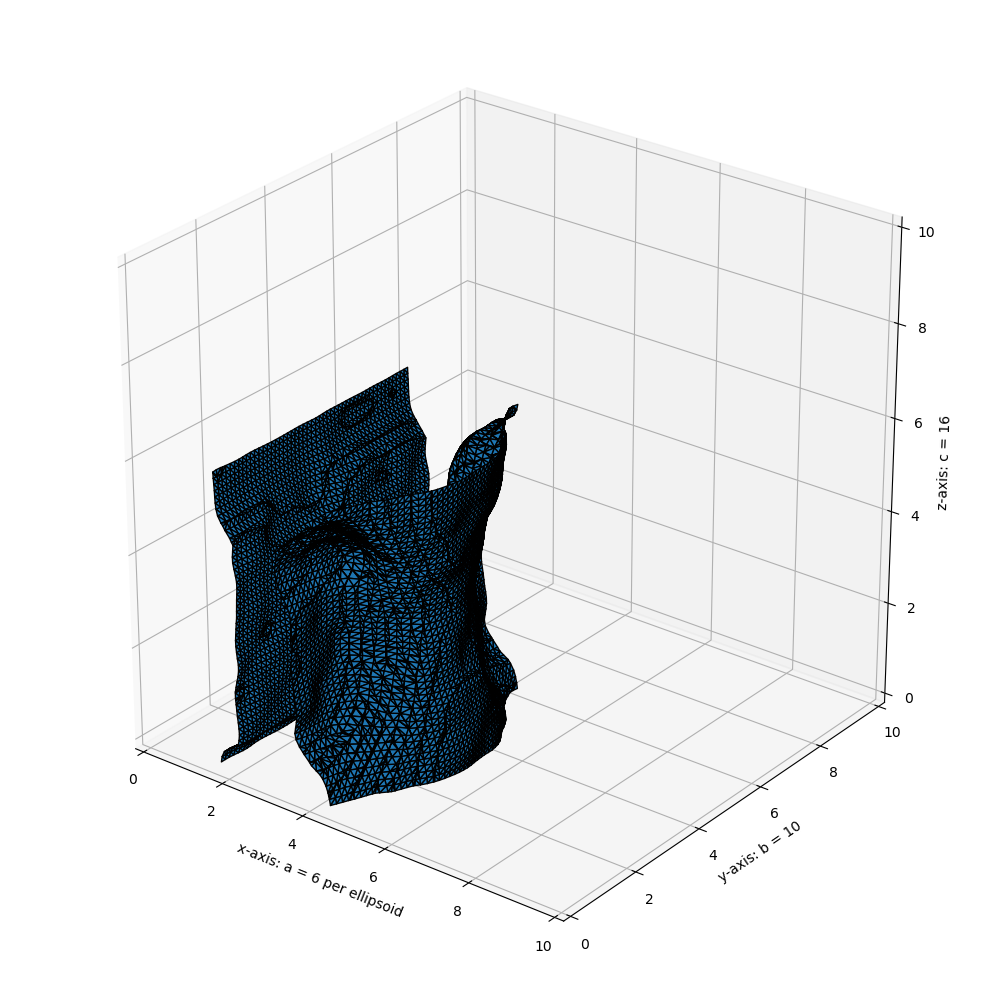

In [6]:
points = vertices[triangle_indices]
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(points)
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 10)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 10)  # b = 10
ax.set_zlim(0, 10)  # c = 16

plt.tight_layout()
plt.show()

In [269]:
np.abs(curve_select).mean(axis=0)

array([0.58980169, 0.6004041 ])

<IPython.core.display.Javascript object>


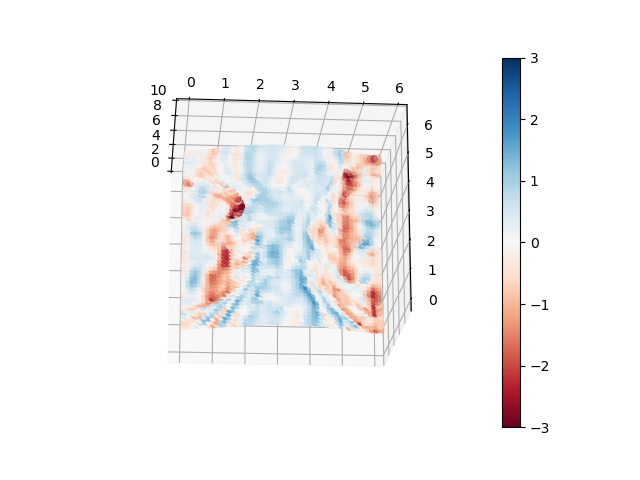

In [271]:
idx = np.argwhere(vertices[:,0] >3.2)
idx = idx.flatten()
curve_select = cuve[idx]
vert_select = vertices[idx]

points = vertices[triangle_indices]
p = points.reshape(-1,3)

fig = plt.figure()
ax = plt.axes(projection ='3d')  

m = ax.scatter(vert_select[:,0],vert_select[:,1],vert_select[:,2],vmin=-3, vmax=3, c=curve_select[:,1],cmap='RdBu')
ax.set_xlim(0,10)
cbar = fig.colorbar(m)

In [ ]:
neighbors = [[] for _ in range(vertices.shape[0])]
curvatureVal = [[] for _ in range(vertices.shape[0])]
curvaturevalue = np.ones((vertices.shape[0],))
neighbornums = np.zeros((vertices.shape[0],))

for i in range(triangle_indices.shape[0]):
    t = triangle_indices[i]
    
    for j in range(3):
        i1 = t[j]
        for k in range(j+1,3):
            i2 = t[k]
            if i2 not in neighbors[i1]:
                diff = vertices[i1] - vertices[i2]
                diffsq = (diff**2).sum()

                n1 = normals[i1]
                n2 = normals[i2]

                diffn = n1 - n2

                dotproduct = np.dot(diffn, diff)
                val = dotproduct/diffsq

                curvatureVal[i1].append(val)
                curvatureVal[i2].append(val)
                neighbors[i1].append(i2)
                neighbors[i2].append(i1)
                neighbornums[i1] += 1
                neighbornums[i2] += 1
                curvaturevalue[i1] *= abs(val)
                curvaturevalue[i2] *= abs(val)
curvaturevalue = curvaturevalue**(1/neighbornums)

In [ ]:
ix = np.argwhere(vertices[:,0] > 3.2)
c = curvaturevalue[ix]

In [ ]:
curvatureVal

In [ ]:
triangle_indices[12270]

In [ ]:
np.argwhere(triangle_indices == 6236)

In [ ]:
vertices[6236]

In [ ]:
normals[6236]

In [62]:
# calculate triangle areas
points = vertices[triangle_indices]
side1 = points[:,1] - points[:,0]
side2 = points[:,0] - points[:,2]
area = np.sqrt((np.cross(side1,side2)**2).sum(axis=1))/2


vertex_neighbor_area = np.zeros((vertices.shape[0],))
vertex_matrix = np.zeros((vertices.shape[0],3,3))

for (i,val) in enumerate(points):
    # index of the triangles in the vertex data
    t = triangle_indices[i]
    A = area[i]
    print(i)
    for j in range(3):
        norm = normals[t[j]]
        vert = vertices[t[j]]
        dyad = np.outer(norm, norm)
        tangential = np.eye(3) - dyad
        for k in range(3):
            if (j != k):
                diff = vertices[t[k]] - vert
                diffsq = (diff**2).sum()
                
                k = 2* np.dot(diff, norm)/diffsq
                T = np.dot(tangential, diff)
                T = T/np.sqrt((T**2).sum())
                
                matrix = A*k*np.outer(T,T)
                vertex_matrix[t[j]] += matrix         
                vertex_neighbor_area[t[j]] += A

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462


4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405


5987
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999
6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124
6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
6139
6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186


7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850
7851
7852
7853
7854
7855
7856
7857
7858
7859
7860
7861
7862
7863
7864
7865
7866
7867
7868
7869
7870
7871
7872
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892
7893
7894
7895
7896
7897
7898
7899
7900
7901
7902
7903
7904
7905
7906
7907
7908
7909
7910
7911
7912
7913
7914
7915
7916
7917
7918
7919
7920
7921
7922
7923
7924
7925
7926
7927
7928
7929
7930
7931
7932
7933


9680
9681
9682
9683
9684
9685
9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698
9699
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
9715
9716
9717
9718
9719
9720
9721
9722
9723
9724
9725
9726
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738
9739
9740
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878
9879


11272
11273
11274
11275
11276
11277
11278
11279
11280
11281
11282
11283
11284
11285
11286
11287
11288
11289
11290
11291
11292
11293
11294
11295
11296
11297
11298
11299
11300
11301
11302
11303
11304
11305
11306
11307
11308
11309
11310
11311
11312
11313
11314
11315
11316
11317
11318
11319
11320
11321
11322
11323
11324
11325
11326
11327
11328
11329
11330
11331
11332
11333
11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
11348
11349
11350
11351
11352
11353
11354
11355
11356
11357
11358
11359
11360
11361
11362
11363
11364
11365
11366
11367
11368
11369
11370
11371
11372
11373
11374
11375
11376
11377
11378
11379
11380
11381
11382
11383
11384
11385
11386
11387
11388
11389
11390
11391
11392
11393
11394
11395
11396
11397
11398
11399
11400
11401
11402
11403
11404
11405
11406
11407
11408
11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
1143

13143
13144
13145
13146
13147


In [70]:
idx[50]

array([89])

In [69]:
vertices[50]

array([5.55716  , 2.419    , 0.0633001])

In [68]:
idx = np.argwhere(vertices[:,0] > 3.2)

In [71]:
ix = 89

l = vertex_matrix[ix]/vertex_neighbor_area[ix]
x = np.array([1,0,0])
E1 = (x - normals[ix])
E1 = E1/np.sqrt((E1**2).sum())
Q = np.eye(3) - 2*np.outer(E1,E1)
res = (Q.T).dot(l).dot(Q)
eigv, eigvec = np.linalg.eig(res[1:,1:])
k1 = 3*eigv[0] - eigv[1]
k2 = 3*eigv[1] - eigv[0]
print("k1 = ", k1)
print("k2 = ", k2)

k1 =  2.709103130174383
k2 =  0.21727014584846538


In [72]:
np.linalg.eig(l)

(array([1.04307244e+00, 2.42392911e-14, 4.20114196e-01]),
 array([[-0.67668481,  0.71461449, -0.17726759],
        [ 0.73009903,  0.68238568, -0.03612747],
        [-0.09514765,  0.15386981,  0.98349937]]))